In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pymc.variational.callbacks import CheckParametersConvergence
from patsy import bs, dmatrix
import matplotlib.dates as mdates
#import bambi as bm

# Load in the data

In [2]:
data = pd.read_csv("./student_math_clean.csv")

In [3]:
data.head()

student_id school sex  age address_type              family_size  \
0           1     GP   F   18        Urban           Greater than 3   
1           2     GP   F   17        Urban           Greater than 3   
2           3     GP   F   15        Urban  Less than or equal to 3   
3           4     GP   F   15        Urban           Greater than 3   
4           5     GP   F   16        Urban           Greater than 3   

     parent_status               mother_education  \
0            Apart               higher education   
1  Living together  primary education (4th grade)   
2  Living together  primary education (4th grade)   
3  Living together               higher education   
4  Living together            secondary education   

                father_education mother_job  ... family_relationship  \
0               higher education    at_home  ...                   4   
1  primary education (4th grade)    at_home  ...                   5   
2  primary education (4th grade)    at_home  ...                   4   
3               5th to 9th grade     health  ...                   3   
4            secondary education      other  ...                   4   

  free_time social weekday_alcohol weekend_alcohol  health absences grade_1  \
0         3      4               1               1       3        6       5   
1         3      3               1               1       3        4       5   
2         3      2               2               3       3       10       7   
3         2      2               1               1       5        2      15   
4         3      2               1               2       5        4       6   

  grade_2 final_grade  
0       6           6  
1       5           6  
2       8          10  
3      14          15  
4      10          10  

[5 rows x 34 columns]

In [4]:
data.columns

Index(['student_id', 'school', 'sex', 'age', 'address_type', 'family_size',
       'parent_status', 'mother_education', 'father_education', 'mother_job',
       'father_job', 'school_choice_reason', 'guardian', 'travel_time',
       'study_time', 'class_failures', 'school_support', 'family_support',
       'extra_paid_classes', 'activities', 'nursery_school', 'higher_ed',
       'internet_access', 'romantic_relationship', 'family_relationship',
       'free_time', 'social', 'weekday_alcohol', 'weekend_alcohol', 'health',
       'absences', 'grade_1', 'grade_2', 'final_grade'],
      dtype='object')

# Exploratory Data Analysis

In [5]:
data.dtypes

student_id                int64
school                   object
sex                      object
age                       int64
address_type             object
family_size              object
parent_status            object
mother_education         object
father_education         object
mother_job               object
father_job               object
school_choice_reason     object
guardian                 object
travel_time              object
study_time               object
class_failures            int64
school_support           object
family_support           object
extra_paid_classes       object
activities               object
nursery_school           object
higher_ed                object
internet_access          object
romantic_relationship    object
family_relationship       int64
free_time                 int64
social                    int64
weekday_alcohol           int64
weekend_alcohol           int64
health                    int64
absences                  int64
grade_1 

In [6]:
data.isna().sum()

student_id               0
school                   0
sex                      0
age                      0
address_type             0
family_size              0
parent_status            0
mother_education         0
father_education         0
mother_job               0
father_job               0
school_choice_reason     0
guardian                 0
travel_time              0
study_time               0
class_failures           0
school_support           0
family_support           0
extra_paid_classes       0
activities               0
nursery_school           0
higher_ed                0
internet_access          0
romantic_relationship    0
family_relationship      0
free_time                0
social                   0
weekday_alcohol          0
weekend_alcohol          0
health                   0
absences                 0
grade_1                  0
grade_2                  0
final_grade              0
dtype: int64

Select only the columns that have integer values to look at correlations

In [125]:
int_columns = data.select_dtypes(include=np.number).columns.to_list()

In [126]:
int_columns

['student_id',
 'age',
 'class_failures',
 'family_relationship',
 'free_time',
 'social',
 'weekday_alcohol',
 'weekend_alcohol',
 'health',
 'absences',
 'grade_1',
 'grade_2',
 'final_grade']

In [9]:
corr_df = data[int_columns]
corr_df.corr()

student_id       age  class_failures  \
student_id             1.000000  0.758057        0.026426   
age                    0.758057  1.000000        0.243665   
class_failures         0.026426  0.243665        1.000000   
family_relationship   -0.016190  0.053940       -0.044337   
free_time              0.003895  0.016434        0.091987   
social                 0.068811  0.126964        0.124561   
weekday_alcohol        0.086302  0.131125        0.136047   
weekend_alcohol        0.095454  0.117276        0.141962   
health                -0.088902 -0.062187        0.065827   
absences               0.065966  0.175230        0.063726   
grade_1                0.046963 -0.064081       -0.354718   
grade_2               -0.053344 -0.143474       -0.355896   
final_grade           -0.099991 -0.161579       -0.360415   

                     family_relationship  free_time    social  \
student_id                     -0.016190   0.003895  0.068811   
age                             0.053940   0.016434  0.126964   
class_failures                 -0.044337   0.091987  0.124561   
family_relationship             1.000000   0.150701  0.064568   
free_time                       0.150701   1.000000  0.285019   
social                          0.064568   0.285019  1.000000   
weekday_alcohol                -0.077594   0.209001  0.266994   
weekend_alcohol                -0.113397   0.147822  0.420386   
health                          0.094056   0.075733 -0.009577   
absences                       -0.044354  -0.058078  0.044302   
grade_1                         0.022168   0.012613 -0.149104   
grade_2                        -0.018281  -0.013777 -0.162250   
final_grade                     0.051363   0.011307 -0.132791   

                     weekday_alcohol  weekend_alcohol    health  absences  \
student_id                  0.086302         0.095454 -0.088902  0.065966   
age                         0.131125         0.117276 -0.062187  0.175230   
class_failures              0.136047         0.141962  0.065827  0.063726   
family_relationship        -0.077594        -0.113397  0.094056 -0.044354   
free_time                   0.209001         0.147822  0.075733 -0.058078   
social                      0.266994         0.420386 -0.009577  0.044302   
weekday_alcohol             1.000000         0.647544  0.077180  0.111908   
weekend_alcohol             0.647544         1.000000  0.092476  0.136291   
health                      0.077180         0.092476  1.000000 -0.029937   
absences                    0.111908         0.136291 -0.029937  1.000000   
grade_1                    -0.094159        -0.126179 -0.073172 -0.031003   
grade_2                    -0.064120        -0.084927 -0.097720 -0.031777   
final_grade                -0.054660        -0.051939 -0.061335  0.034247   

                      grade_1   grade_2  final_grade  
student_id           0.046963 -0.053344    -0.099991  
age                 -0.064081 -0.143474    -0.161579  
class_failures      -0.354718 -0.355896    -0.360415  
family_relationship  0.022168 -0.018281     0.051363  
free_time            0.012613 -0.013777     0.011307  
social              -0.149104 -0.162250    -0.132791  
weekday_alcohol     -0.094159 -0.064120    -0.054660  
weekend_alcohol     -0.126179 -0.084927    -0.051939  
health              -0.073172 -0.097720    -0.061335  
absences            -0.031003 -0.031777     0.034247  
grade_1              1.000000  0.852118     0.801468  
grade_2              0.852118  1.000000     0.904868  
final_grade          0.801468  0.904868     1.000000

<Axes: >

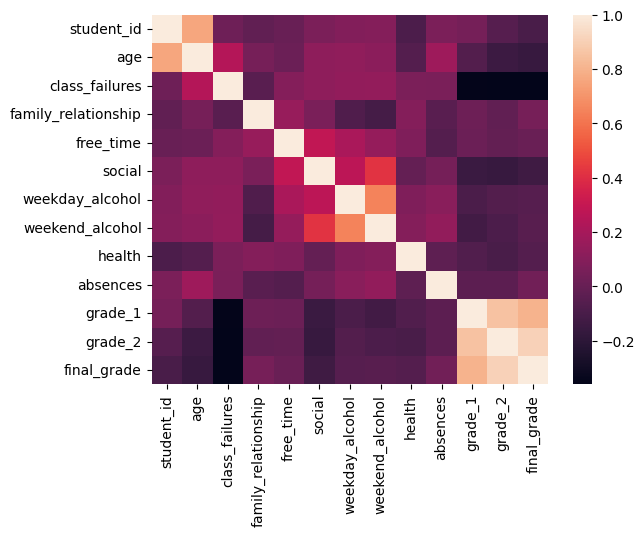

In [10]:
sns.heatmap(corr_df.corr())

As expected, the highly correlated variables are the grades. Not unusual

Let's do the same thing with the categorical variables

In [11]:
cat_columns = data.select_dtypes(include='object').columns.to_list()


In [12]:
for col in cat_columns:
    print(data[col].value_counts())
    print('\n')

GP    349
MS     46
Name: school, dtype: int64


F    208
M    187
Name: sex, dtype: int64


Urban    307
Rural     88
Name: address_type, dtype: int64


Greater than 3             281
Less than or equal to 3    114
Name: family_size, dtype: int64


Living together    354
Apart               41
Name: parent_status, dtype: int64


higher education                 131
5th to 9th grade                 103
secondary education               99
primary education (4th grade)     59
none                               3
Name: mother_education, dtype: int64


5th to 9th grade                 115
secondary education              100
higher education                  96
primary education (4th grade)     82
none                               2
Name: father_education, dtype: int64


other       141
services    103
at_home      59
teacher      58
health       34
Name: mother_job, dtype: int64


other       217
services    111
teacher      29
at_home      20
health       18
Name: father_job, dtype: in

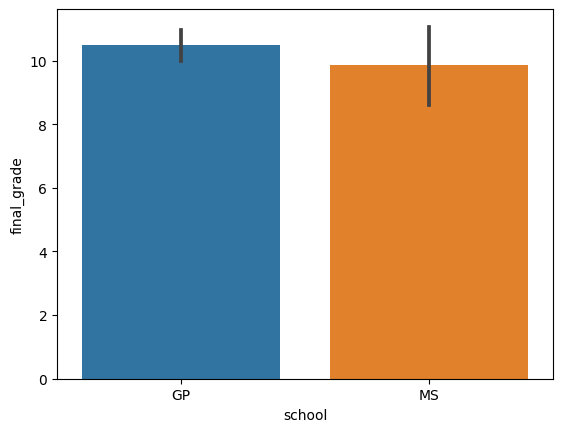

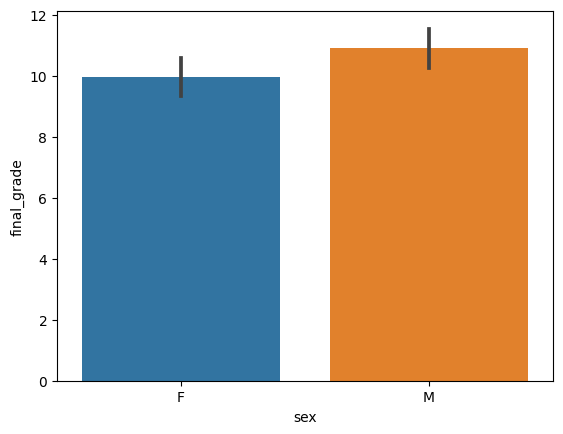

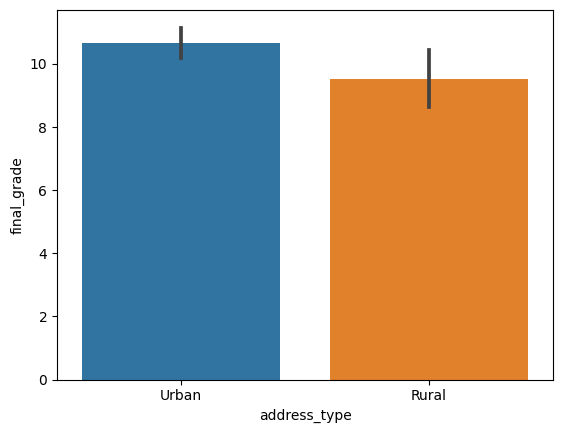

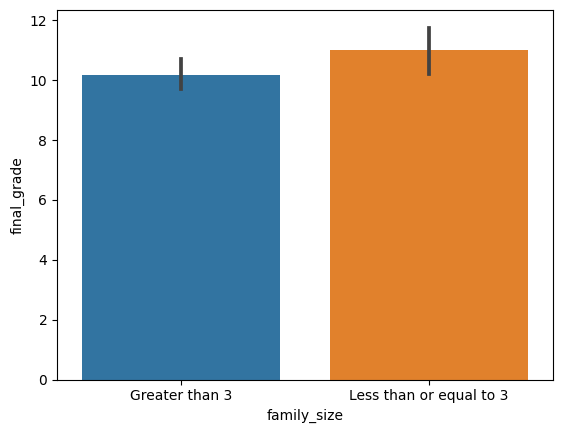

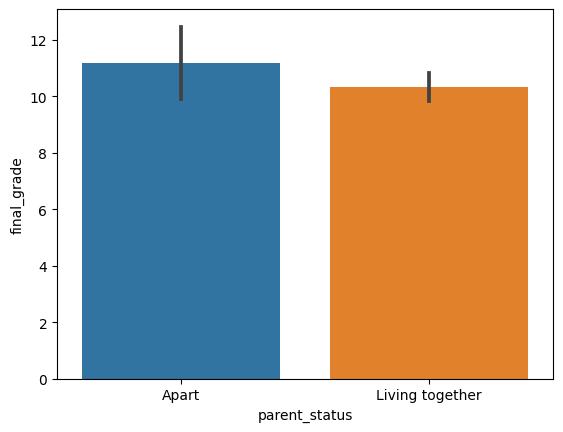

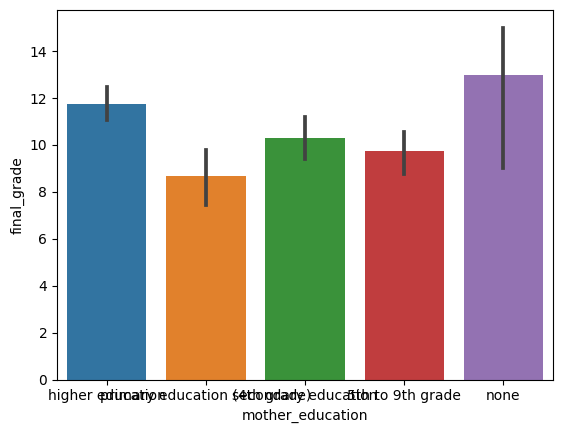

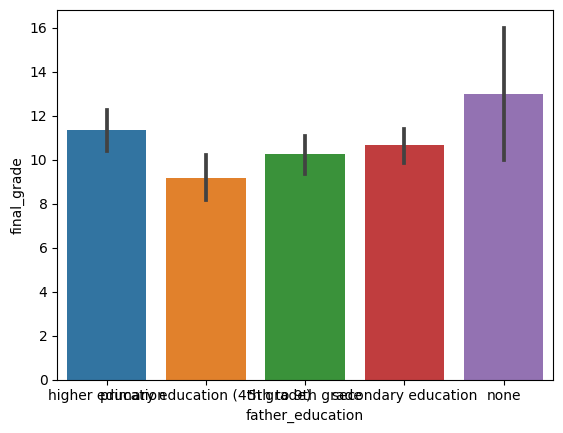

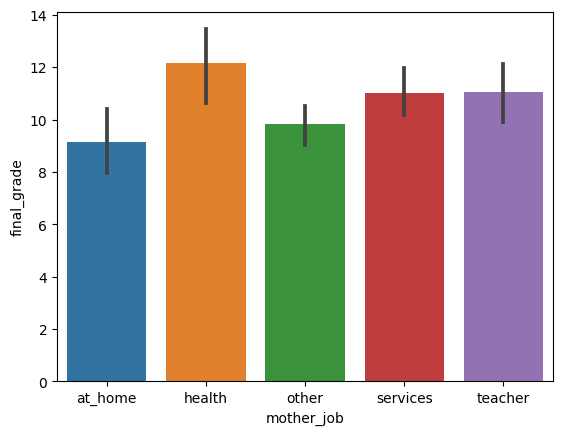

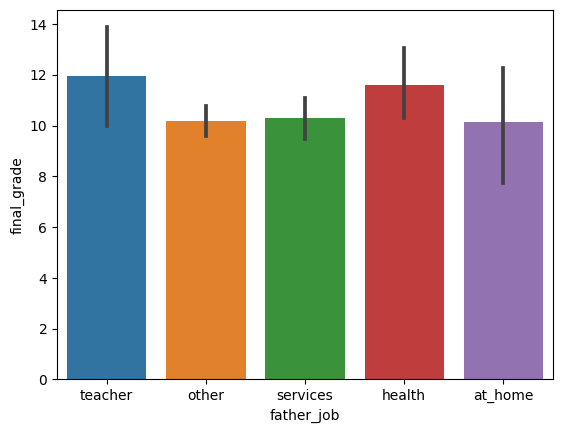

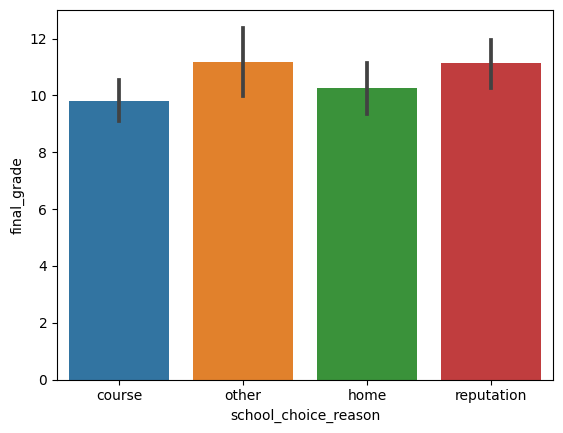

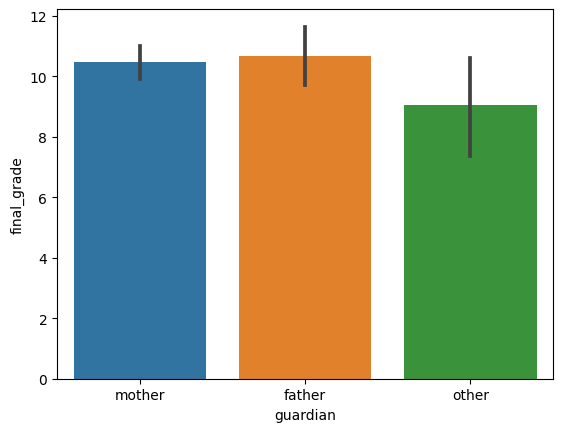

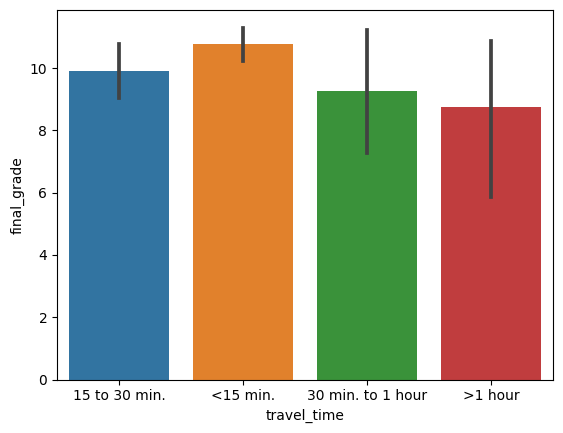

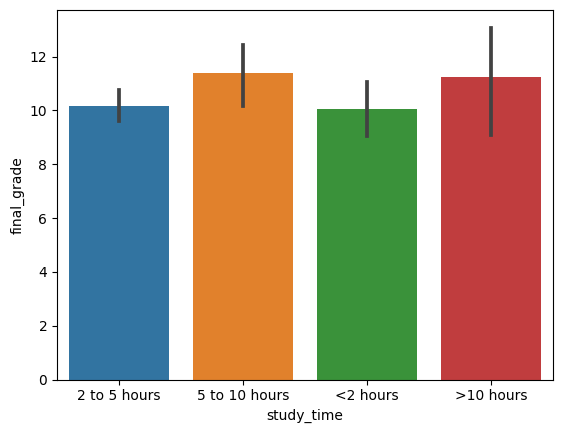

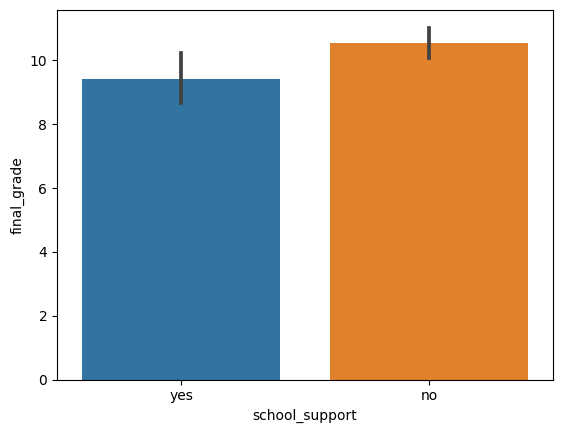

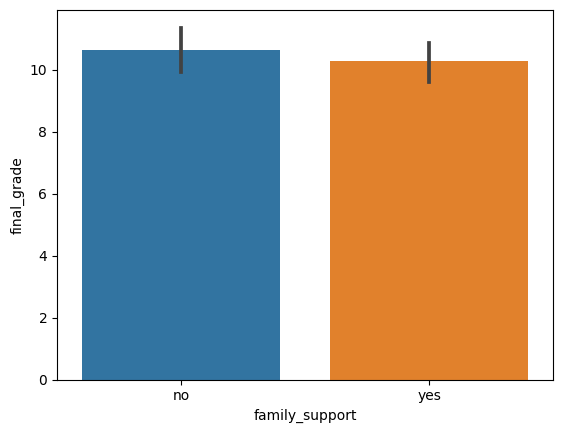

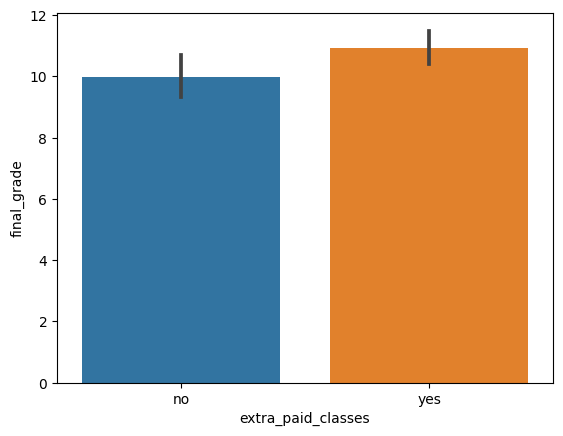

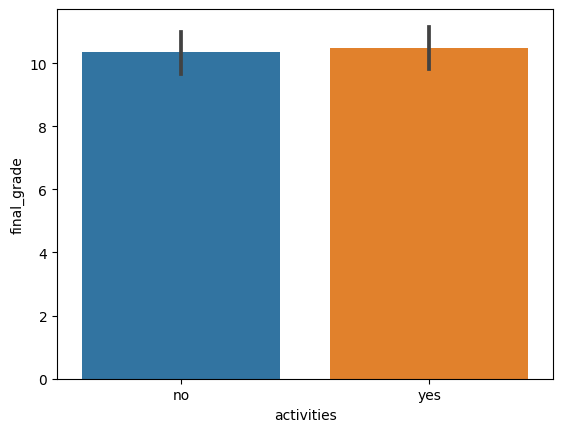

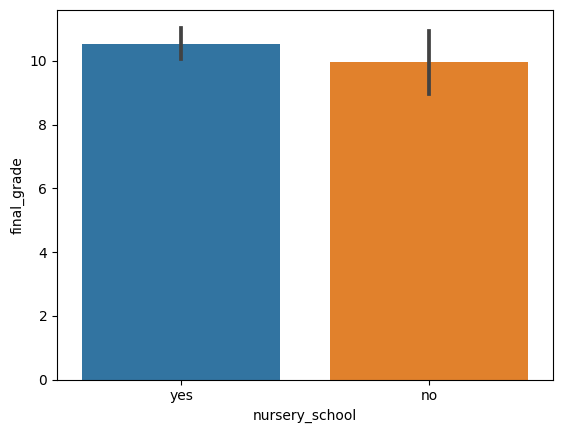

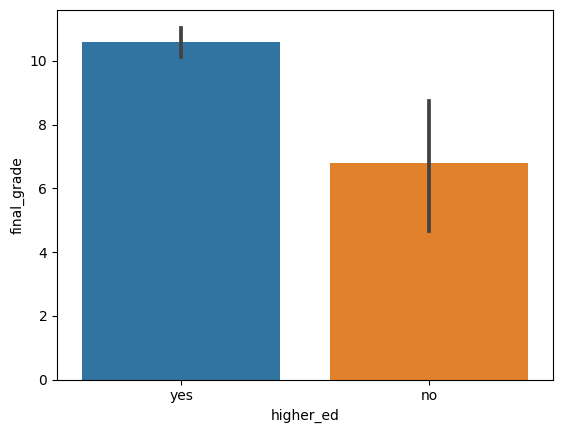

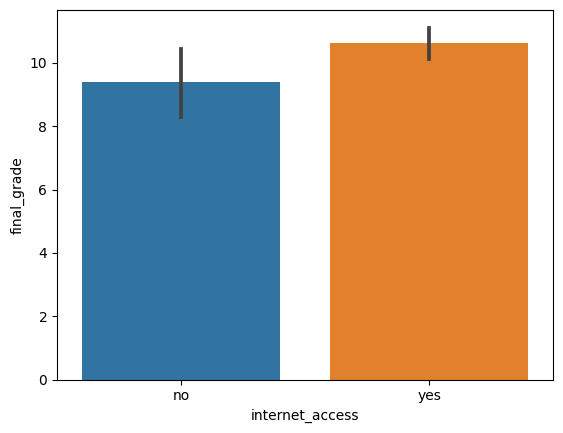

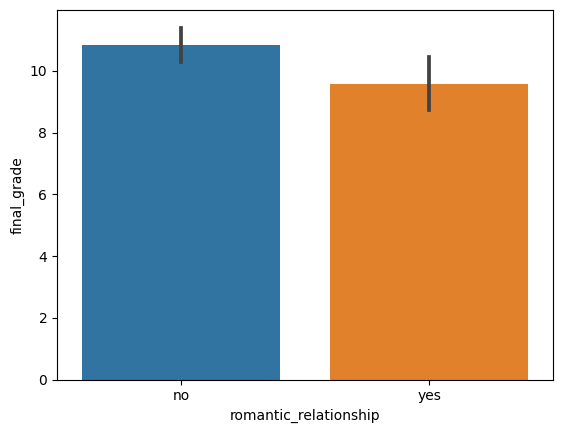

In [13]:
for col in cat_columns:
    sns.barplot(data, x = data[col], y= data['final_grade'])
    plt.show()

# Recoding Yes/No Variables

In [14]:
clean = data.copy(deep=True)

In [15]:
replace_map = {'school_support': {'yes':1,'no': 0},
               'family_support': {'yes':1,'no': 0},
               'extra_paid_classes': {'yes':1,'no': 0},
               'activities': {'yes':1,'no': 0},
               'nursery_school': {'yes':1,'no': 0},
               'higher_ed': {'yes':1,'no': 0},
               'internet_access': {'yes':1,'no': 0},
               'romantic_relationship': {'yes':1,'no': 0}}

In [16]:
clean = clean.replace(replace_map)

In [17]:
clean.dtypes

student_id                int64
school                   object
sex                      object
age                       int64
address_type             object
family_size              object
parent_status            object
mother_education         object
father_education         object
mother_job               object
father_job               object
school_choice_reason     object
guardian                 object
travel_time              object
study_time               object
class_failures            int64
school_support            int64
family_support            int64
extra_paid_classes        int64
activities                int64
nursery_school            int64
higher_ed                 int64
internet_access           int64
romantic_relationship     int64
family_relationship       int64
free_time                 int64
social                    int64
weekday_alcohol           int64
weekend_alcohol           int64
health                    int64
absences                  int64
grade_1 

## Bayesian T-Test on Internet Access

In [18]:
test_df = clean[['internet_access','final_grade']]

In [19]:
test_df.head()

internet_access  final_grade
0                0            6
1                1            6
2                1           10
3                1           15
4                0           10

In [20]:
summary_stats = (data.loc[:, ["internet_access", "final_grade"]]
                         .groupby("internet_access")
                         .agg(["mean", "std", "count"]))
summary_stats


final_grade                
                       mean       std count
internet_access                            
no                 9.409091  4.485797    66
yes               10.617021  4.580494   329

In [21]:
y0 = test_df.loc[test_df["internet_access"]==0]['final_grade']
y1 = test_df.loc[test_df["internet_access"]==1]["final_grade"]

mu_prior = test_df.final_grade.mean()
std_prior = test_df.final_grade.std() * 2

sigma_low = 1
sigma_high = 100

In [22]:
with pm.Model() as t_test:
    noAccess_mean = pm.Normal("noAccess_mean", mu=mu_prior, sigma=std_prior)
    yesAccess_mean = pm.Normal("yesAccess_mean", mu=mu_prior, sigma=std_prior)
    noAccess_std = pm.Uniform("noAccess_std", lower=sigma_low, upper=sigma_high)
    yesAccess_std = pm.Uniform("yesAccess_std", lower=sigma_low, upper=sigma_high)
    nu = pm.Exponential("nu", 1/29)

    noAccess = pm.StudentT("noAccess", nu=nu, mu=noAccess_mean, sigma=noAccess_std, observed=y0)
    yesAccess = pm.StudentT("yesAccess", nu=nu, mu=yesAccess_mean, sigma=yesAccess_std, observed=y1)
    diff_of_means = pm.Deterministic("difference of means", noAccess_mean - yesAccess_mean)
    diff_of_stds = pm.Deterministic("difference of stds", noAccess_std - yesAccess_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((noAccess_std ** 2 + yesAccess_std ** 2) / 2)
    )


    internet_trace=pm.sample(random_seed = 1234, cores = 4)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'noAccess_mean'}>,
        <Axes: title={'center': 'noAccess_mean'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'yesAccess_mean'}>,
        <Axes: title={'center': 'yesAccess_mean'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'noAccess_std'}>,
        <Axes: title={'center': 'noAccess_std'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'yesAccess_std'}>,
        <Axes: title={'center': 'yesAccess_std'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'nu'}>,
        <Axes: title={'center': 'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'difference of means'}>,
        <Axes: title={'center': 'difference of means'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'difference of stds'}>,
        <Axes: title={'center': 'difference of stds'}, xlabel='Rank (all

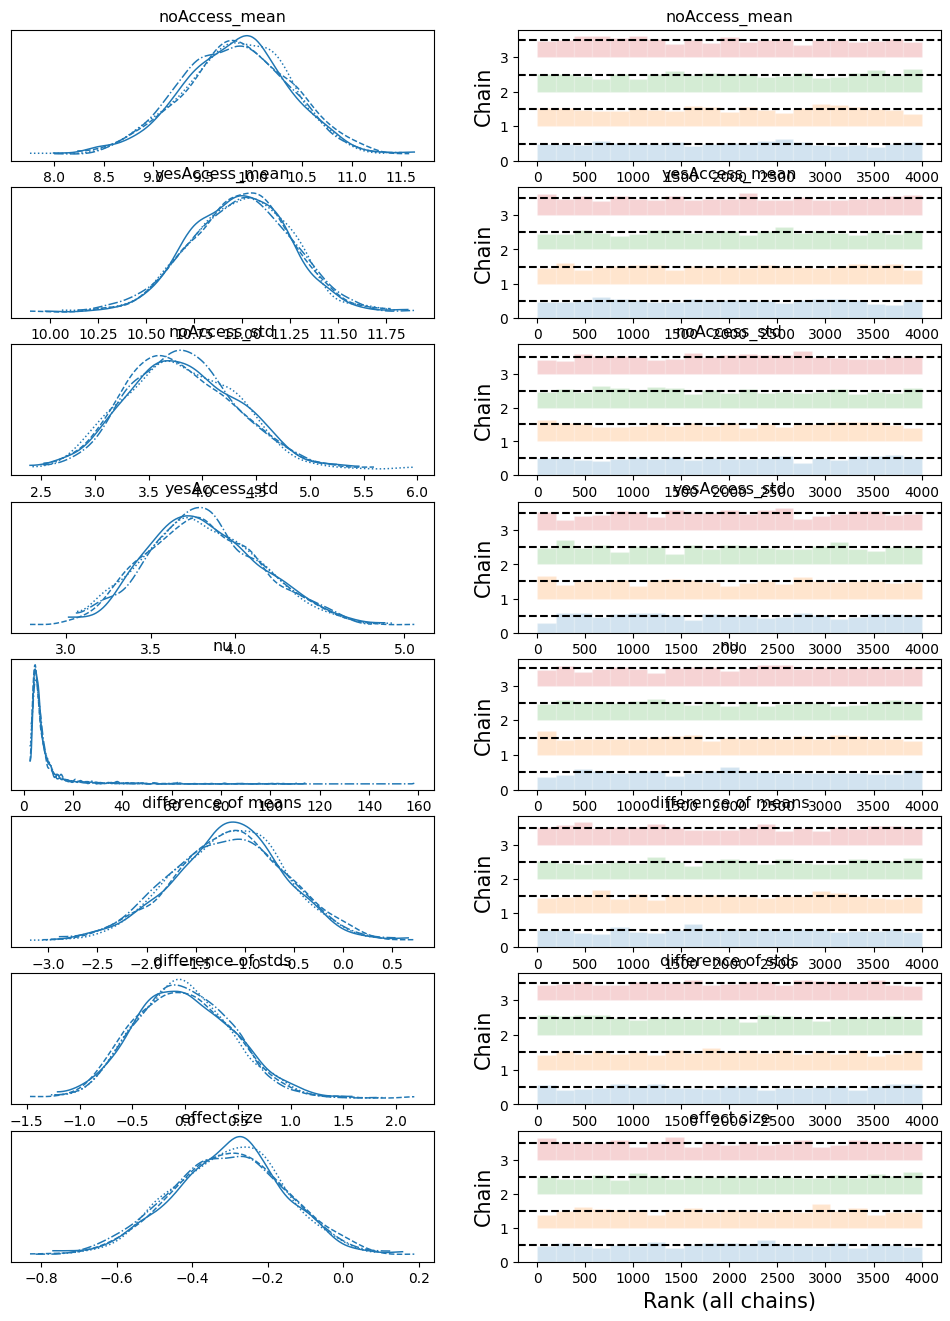

In [23]:
az.plot_trace(internet_trace, kind= 'rank_bars');

In [24]:
az.summary(internet_trace)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
noAccess_mean         9.828   0.541   8.784   10.805      0.011    0.008   
yesAccess_mean       10.991   0.260  10.511   11.466      0.005    0.004   
noAccess_std          3.808   0.510   2.895    4.750      0.012    0.008   
yesAccess_std         3.821   0.343   3.199    4.470      0.009    0.006   
nu                    8.741  10.025   2.526   21.495      0.332    0.235   
difference of means  -1.163   0.576  -2.184   -0.024      0.010    0.008   
difference of stds   -0.013   0.461  -0.823    0.853      0.007    0.007   
effect size          -0.306   0.151  -0.581   -0.018      0.003    0.002   

                     ess_bulk  ess_tail  r_hat  
noAccess_mean          2471.0    2269.0   1.00  
yesAccess_mean         2638.0    2473.0   1.00  
noAccess_std           1879.0    1995.0   1.00  
yesAccess_std          1535.0    1689.0   1.00  
nu                     1305.0    1191.0   1.01  
difference of means    3318.0    2668.0   1.01  
difference of stds     4053.0    2858.0   1.00  
effect size            3420.0    2681.0   1.00

array([<Axes: title={'center': 'difference of means'}>,
       <Axes: title={'center': 'difference of stds'}>,
       <Axes: title={'center': 'effect size'}>], dtype=object)

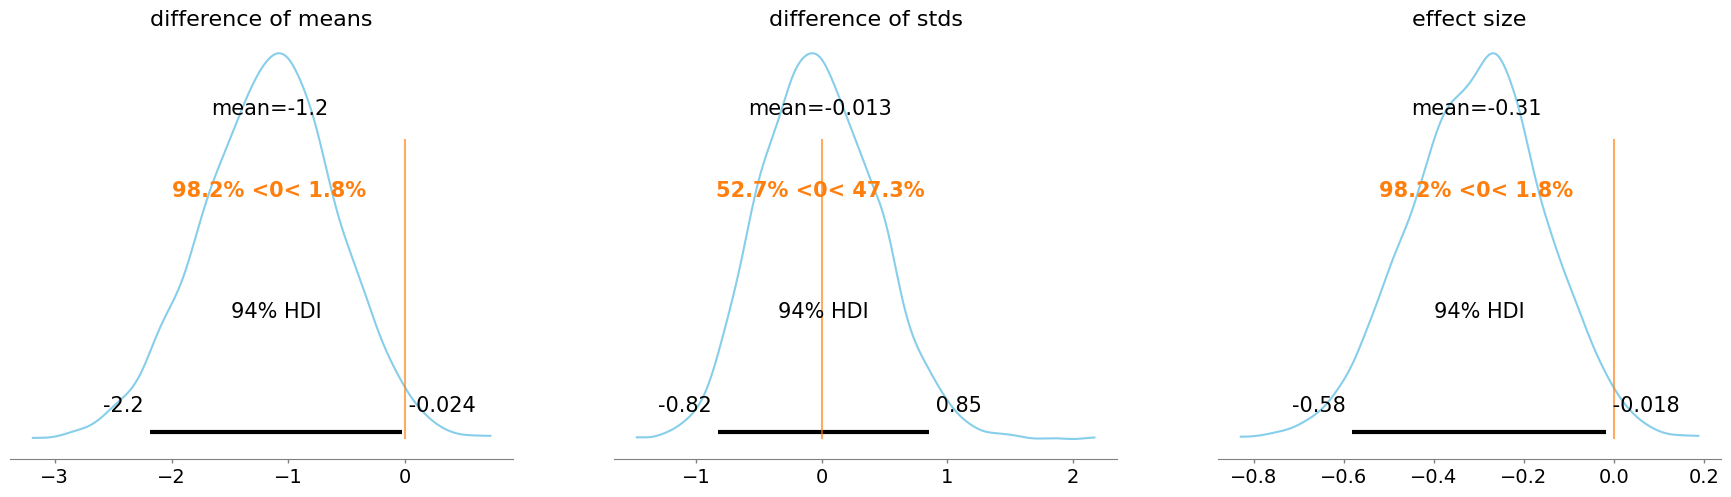

In [25]:
az.plot_posterior(
    internet_trace,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb")

# Trying out Bambi

# Clean data
One-hot coding using get_dummies

In [154]:
dummies_2 = pd.get_dummies(clean, dtype=int)
dummies_2.head()

student_id  age  class_failures  school_support  family_support  \
0           1   18               0               1               0   
1           2   17               0               0               1   
2           3   15               3               1               0   
3           4   15               0               0               1   
4           5   16               0               0               1   

   extra_paid_classes  activities  nursery_school  higher_ed  internet_access  \
0                   0           0               1          1                0   
1                   0           0               0          1                1   
2                   1           0               1          1                1   
3                   1           1               1          1                1   
4                   1           0               1          1                0   

   ...  guardian_mother  guardian_other  travel_time_15 to 30 min.  \
0  ...                1               0                          1   
1  ...                0               0                          0   
2  ...                1               0                          0   
3  ...                1               0                          0   
4  ...                0               0                          0   

   travel_time_30 min. to 1 hour  travel_time_<15 min.  travel_time_>1 hour  \
0                              0                     0                    0   
1                              0                     1                    0   
2                              0                     1                    0   
3                              0                     1                    0   
4                              0                     1                    0   

   study_time_2 to 5 hours  study_time_5 to 10 hours  study_time_<2 hours  \
0                        1                         0                    0   
1                        1                         0                    0   
2                        1                         0                    0   
3                        0                         1                    0   
4                        1                         0                    0   

   study_time_>10 hours  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 66 columns]

Getting rid of odd characters in the column names

In [155]:
dummies_2.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
dummies_2.rename(columns=lambda x: x.replace('(', ''), inplace=True)
dummies_2.rename(columns=lambda x: x.replace(')', ''), inplace=True)
dummies_2.rename(columns=lambda x: x.replace('<', 'less_'), inplace=True)
dummies_2.rename(columns=lambda x: x.replace('>', 'greater_'), inplace=True)

In [156]:
dummies_2.head()

student_id  age  class_failures  school_support  family_support  \
0           1   18               0               1               0   
1           2   17               0               0               1   
2           3   15               3               1               0   
3           4   15               0               0               1   
4           5   16               0               0               1   

   extra_paid_classes  activities  nursery_school  higher_ed  internet_access  \
0                   0           0               1          1                0   
1                   0           0               0          1                1   
2                   1           0               1          1                1   
3                   1           1               1          1                1   
4                   1           0               1          1                0   

   ...  guardian_mother  guardian_other  travel_time_15_to_30_min.  \
0  ...                1               0                          1   
1  ...                0               0                          0   
2  ...                1               0                          0   
3  ...                1               0                          0   
4  ...                0               0                          0   

   travel_time_30_min._to_1_hour  travel_time_less_15_min.  \
0                              0                         0   
1                              0                         1   
2                              0                         1   
3                              0                         1   
4                              0                         1   

   travel_time_greater_1_hour  study_time_2_to_5_hours  \
0                           0                        1   
1                           0                        1   
2                           0                        1   
3                           0                        0   
4                           0                        1   

   study_time_5_to_10_hours  study_time_less_2_hours  \
0                         0                        0   
1                         0                        0   
2                         0                        0   
3                         1                        0   
4                         0                        0   

   study_time_greater_10_hours  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  

[5 rows x 66 columns]

In [29]:
dummies_2.columns

Index(['student_id', 'age', 'class_failures', 'school_support',
       'family_support', 'extra_paid_classes', 'activities', 'nursery_school',
       'higher_ed', 'internet_access', 'romantic_relationship',
       'family_relationship', 'free_time', 'social', 'weekday_alcohol',
       'weekend_alcohol', 'health', 'absences', 'grade_1', 'grade_2',
       'final_grade', 'school_GP', 'school_MS', 'sex_F', 'sex_M',
       'address_type_Rural', 'address_type_Urban',
       'family_size_Greater_than_3', 'family_size_Less_than_or_equal_to_3',
       'parent_status_Apart', 'parent_status_Living_together',
       'mother_education_5th_to_9th_grade',
       'mother_education_higher_education', 'mother_education_none',
       'mother_education_primary_education_4th_grade',
       'mother_education_secondary_education',
       'father_education_5th_to_9th_grade',
       'father_education_higher_education', 'father_education_none',
       'father_education_primary_education_4th_grade',
       'fath

In [157]:
predictors = dummies_2.drop('final_grade',axis=1)

Joining the column names in one long string, separated by a + to use bambi

In [31]:
result = '+'.join(predictors.columns)
result

'student_id+age+class_failures+school_support+family_support+extra_paid_classes+activities+nursery_school+higher_ed+internet_access+romantic_relationship+family_relationship+free_time+social+weekday_alcohol+weekend_alcohol+health+absences+grade_1+grade_2+school_GP+school_MS+sex_F+sex_M+address_type_Rural+address_type_Urban+family_size_Greater_than_3+family_size_Less_than_or_equal_to_3+parent_status_Apart+parent_status_Living_together+mother_education_5th_to_9th_grade+mother_education_higher_education+mother_education_none+mother_education_primary_education_4th_grade+mother_education_secondary_education+father_education_5th_to_9th_grade+father_education_higher_education+father_education_none+father_education_primary_education_4th_grade+father_education_secondary_education+mother_job_at_home+mother_job_health+mother_job_other+mother_job_services+mother_job_teacher+father_job_at_home+father_job_health+father_job_other+father_job_services+father_job_teacher+school_choice_reason_course+scho

In [32]:
#prelim_model = bm.Model('final_grade ~ ' + result,
 #                       data = dummies_2,
 #                       family='gaussian')

#prelim_model

In [33]:
#prelim_results = prelim_model.fit(random_seed=1738)

In [34]:
#az.plot_trace(prelim_results)

In [35]:
#az.summary(prelim_results)

# Variational Inference

Drop student_id

In [158]:
mean = dummies_2.mean()
std = dummies_2.std()
dummies_2 = dummies_2.drop('student_id', axis=1)

## Splitting Integer and Categorical Data Sets to Apply Different Priors

Z Standardizing

In [161]:
new_int_cols = int_columns[1:]
dummies_2_int = dummies_2[new_int_cols]

# standardize integer predictors
mean = dummies_2_int.mean()
std = dummies_2_int.std()

dummies_2_int = (dummies_2_int - mean) / std

In [162]:
dummies_2_cat = dummies_2.drop(new_int_cols, axis=1)
dummies_2_cat.head()

# drop response
dummies_2_int = dummies_2_int.drop('final_grade', axis=1)

In [163]:
X_int = dummies_2_int
k=X_int.shape[1]
n=X_int.shape[0]
Ones = np.ones(n).reshape((n,1))
X_int = np.concatenate((Ones, X_int), axis = 1) #this is for the intercept
print(X_int.shape)

(395, 12)


In [164]:
X_cat = dummies_2_cat
k_cat = X_cat.shape[1]
n_cat = X_cat.shape[0]
Ones_cat = np.ones(n_cat).reshape((n_cat,1))
X_cat = np.concatenate((Ones_cat, X_cat), axis = 1)

Response - cleaning and Z Standardizing

In [165]:
response = pd.read_csv('./student_math_clean.csv')
response = response['final_grade']
response_mean = response.mean()
response_std = response.std()
response = response-response_mean/response_std

age  class_failures  family_relationship  free_time    social  \
0    1.021751       -0.449374             0.062115  -0.235711  0.800464   
1    0.238078       -0.449374             1.177367  -0.235711 -0.097784   
2   -1.329268        3.584777             0.062115  -0.235711 -0.996032   
3   -1.329268       -0.449374            -1.053136  -1.236851 -0.996032   
4   -0.545595       -0.449374             0.062115  -0.235711 -0.996032   
..        ...             ...                  ...        ...       ...   
390  2.589096        2.240060             1.177367   1.766567  0.800464   
391  0.238078       -0.449374            -2.168388   0.765428  1.698712   
392  3.372769        3.584777             1.177367   1.766567 -0.097784   
393  1.021751       -0.449374             0.062115   0.765428 -1.894280   
394  1.805423       -0.449374            -1.053136  -1.236851 -0.097784   

     weekday_alcohol  weekend_alcohol    health  absences   grade_1   grade_2  
0          -0.540014        -1.002518 -0.398784  0.036378 -1.780209 -1.253202  
1          -0.540014        -1.002518 -0.398784 -0.213525 -1.780209 -1.519053  
2           0.582646         0.550402 -0.398784  0.536185 -1.177653 -0.721500  
3          -0.540014        -1.002518  1.039751 -0.463428  1.232570  0.873607  
4          -0.540014        -0.226058  1.039751 -0.213525 -1.478931 -0.189797  
..               ...              ...       ...       ...       ...       ...  
390         2.827967         2.103322  0.320484  0.661137 -0.575098 -0.455649  
391         1.705307         1.326862 -1.118051 -0.338477  0.931292  1.405309  
392         1.705307         0.550402 -0.398784 -0.338477 -0.273820 -0.721500  
393         1.705307         1.326862  1.039751 -0.713332  0.027458  0.341905  
394         1.705307         0.550402  1.039751 -0.088573 -0.876375 -0.455649  

[395 rows x 11 columns]

## Creating a Model

In [84]:
with pm.Model() as grade_model:
    β_continuous = pm.StudentT('β_continuous', nu=3, mu=0, lam=1, shape=X_int.shape[1])
    β_binary = pm.Normal('β_binary', mu=0, sigma=1, shape=X_cat.shape[1])

    # Combine beta coefficients
    β = pm.math.concatenate([β_continuous, β_binary])

    # Calculate the linear combination
    μ = pm.math.dot(X_int, β[:X_int.shape[1]]) + pm.math.dot(X_cat, β[X_int.shape[1]:])

    # Define the likelihood (normal distribution for continuous response)
    y_obs = pm.Normal('y_obs', mu=μ, sigma=1, observed=response)


g = pm.model_to_graphviz(grade_model)
g.render()


'.gv.pdf'

## Using ADVI

In [85]:
with grade_model:
    # Variational fit with ADVI optimization
    advi_fit = pm.fit(100000, method='advi', random_seed = 123)

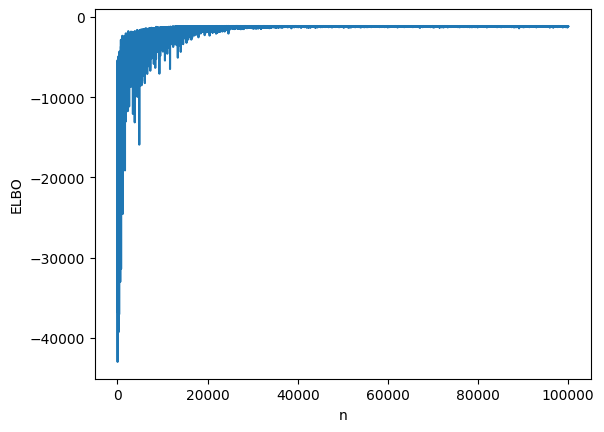

In [86]:
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

Text(0.5, 1.0, 'Std track')

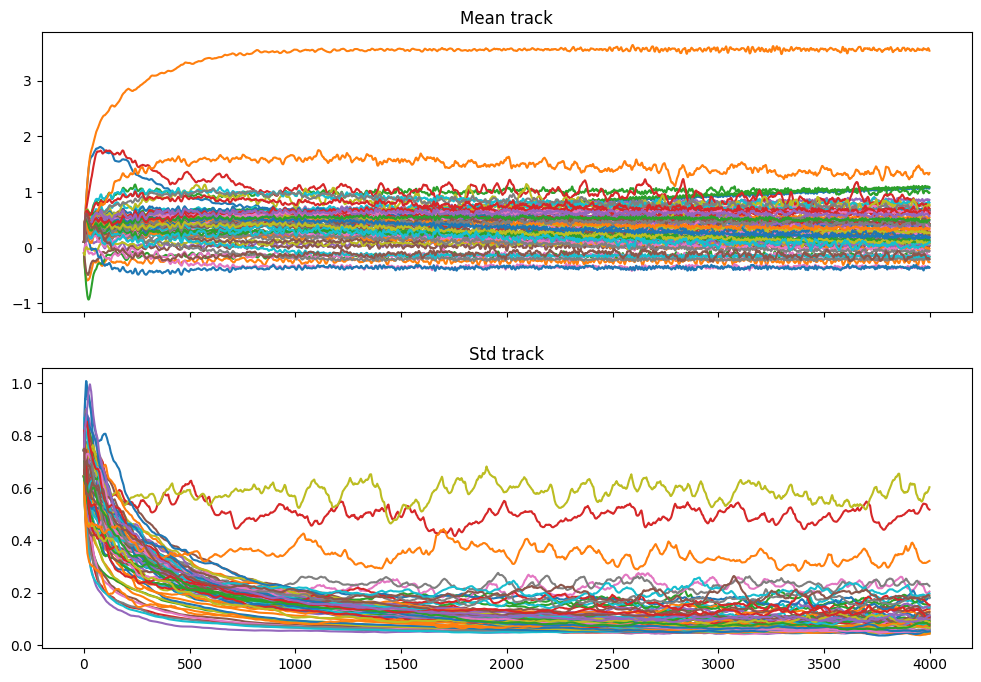

In [87]:
with grade_model:
    #Variational fit with SVGD
    advi_approx = pm.ADVI(n_particles=500, jitter=1)
#create tracker to check convergence
tracker = pm.callbacks.Tracker(
    mean=advi_approx.approx.mean.eval,  # callable that returns mean
    std=advi_approx.approx.std.eval,  # callable that returns std
)

#fit model and keep track of mean and std to check for convergence
approx = advi_approx.fit(4000,
                         callbacks=[tracker],
                         obj_optimizer=pm.adamax(learning_rate=0.1))

#plot convergence plots
fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(12, 8))
ax1.plot(tracker["mean"])
ax1.set_title("Mean track")
ax2.plot(tracker["std"])
ax2.set_title("Std track")

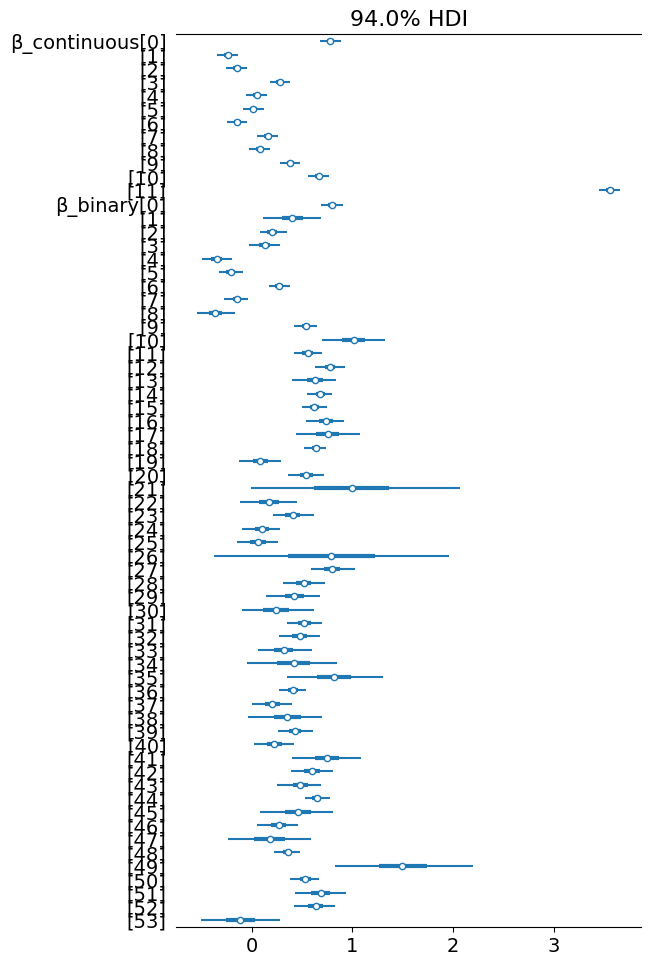

In [88]:
grade_advi_trace = advi_fit.sample(5000)
with grade_model:
    az.plot_forest(grade_advi_trace)

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (66) in plot_posterior, generating only 40 plots
  warnings.warn(


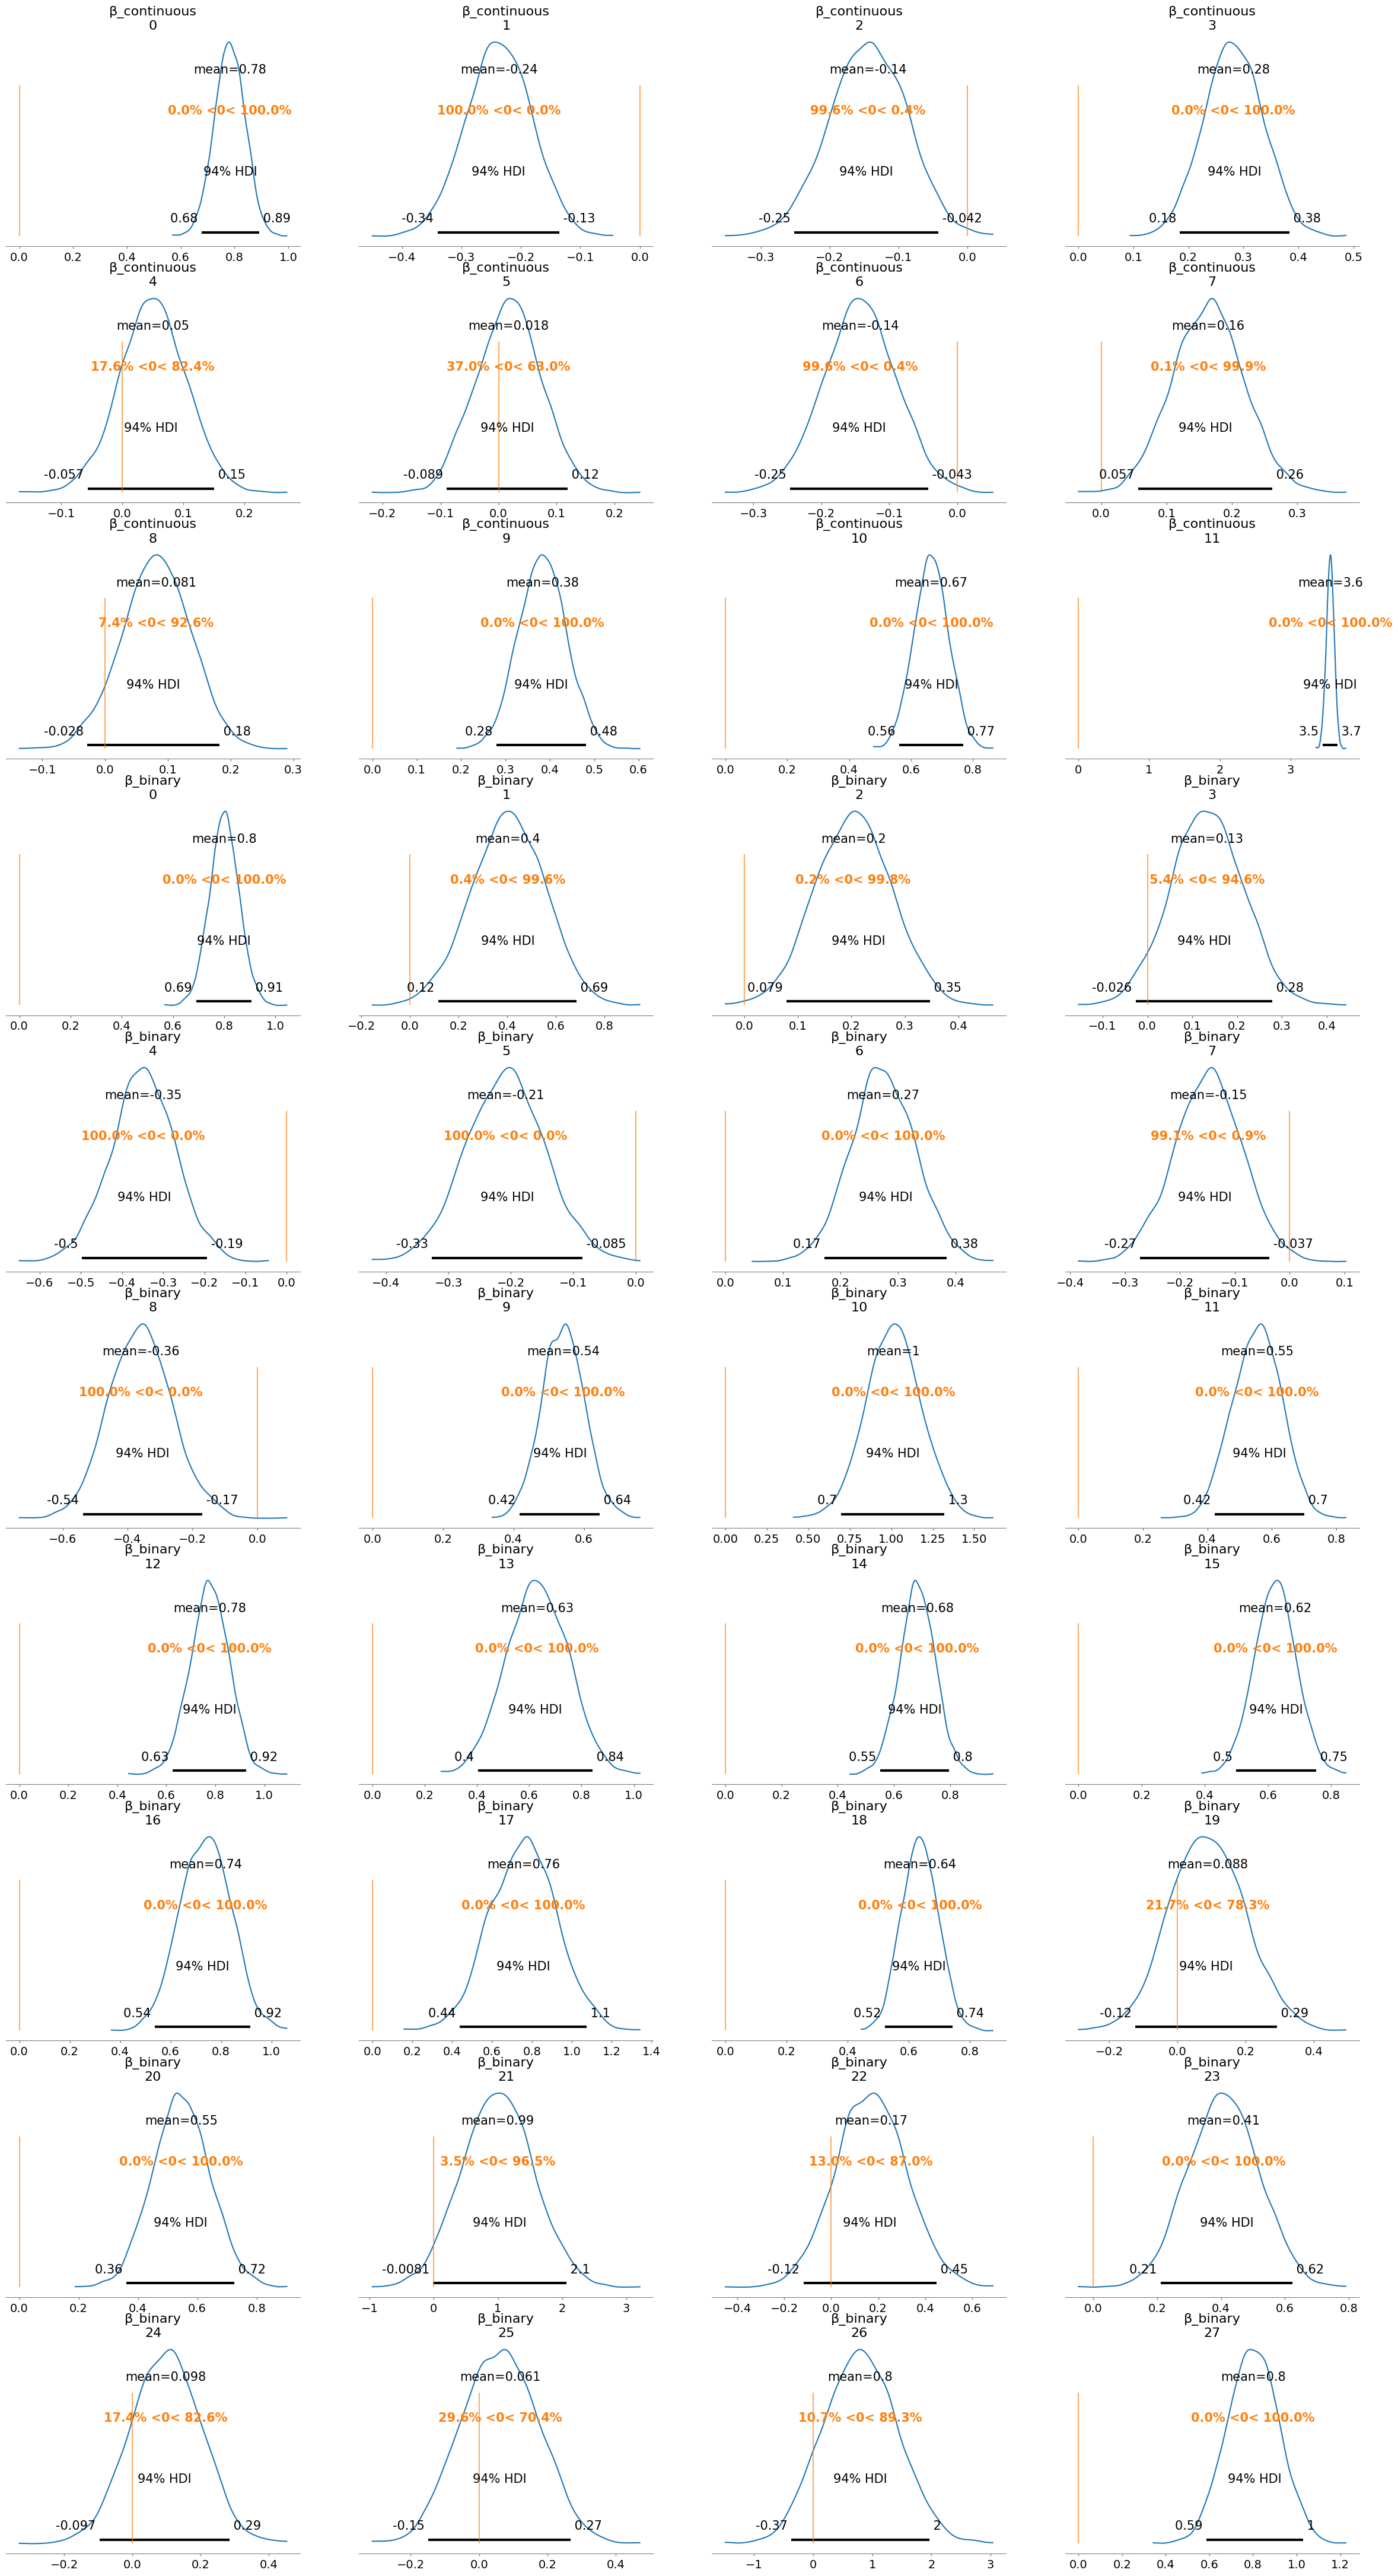

In [290]:
az.plot_posterior(
    grade_advi_trace, ref_val = 0
);

In [49]:
dummies_2_int.columns

Index(['age', 'class_failures', 'family_relationship', 'free_time', 'social',
       'weekday_alcohol', 'weekend_alcohol', 'health', 'absences', 'grade_1',
       'grade_2'],
      dtype='object')

In [90]:
dummies_2_cat.columns

Index(['school_support', 'family_support', 'extra_paid_classes', 'activities',
       'nursery_school', 'higher_ed', 'internet_access',
       'romantic_relationship', 'school_GP', 'school_MS', 'sex_F', 'sex_M',
       'address_type_Rural', 'address_type_Urban',
       'family_size_Greater_than_3', 'family_size_Less_than_or_equal_to_3',
       'parent_status_Apart', 'parent_status_Living_together',
       'mother_education_5th_to_9th_grade',
       'mother_education_higher_education', 'mother_education_none',
       'mother_education_primary_education_4th_grade',
       'mother_education_secondary_education',
       'father_education_5th_to_9th_grade',
       'father_education_higher_education', 'father_education_none',
       'father_education_primary_education_4th_grade',
       'father_education_secondary_education', 'mother_job_at_home',
       'mother_job_health', 'mother_job_other', 'mother_job_services',
       'mother_job_teacher', 'father_job_at_home', 'father_job_health',
   

## With SVGD

Text(0.5, 1.0, 'Std track')

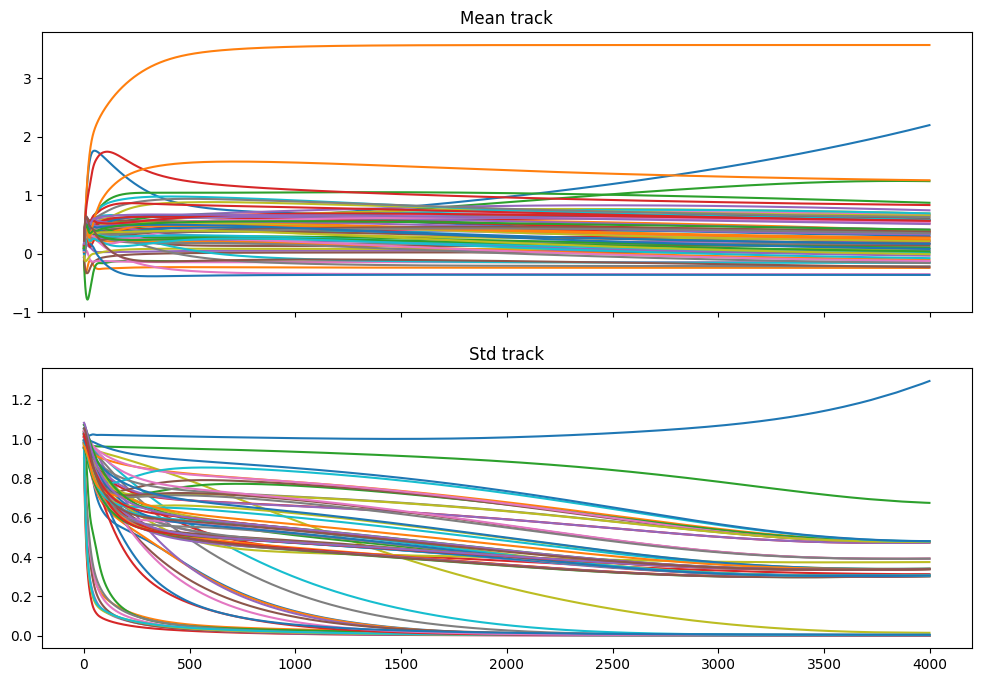

In [91]:
with grade_model:
    #Variational fit with SVGD
    svgd_approx = pm.SVGD(n_particles=500, jitter=1)

#create tracker to check convergence
tracker = pm.callbacks.Tracker(
    mean=svgd_approx.approx.mean.eval,  # callable that returns mean
    std=svgd_approx.approx.std.eval,  # callable that returns std
)

#fit model and keep track of mean and std to check for convergence
approx = svgd_approx.fit(4000,
                         callbacks=[tracker],
                         obj_optimizer=pm.adamax(learning_rate=0.1))

#plot convergence plots
fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(12, 8))
ax1.plot(tracker["mean"])
ax1.set_title("Mean track")
ax2.plot(tracker["std"])
ax2.set_title("Std track")

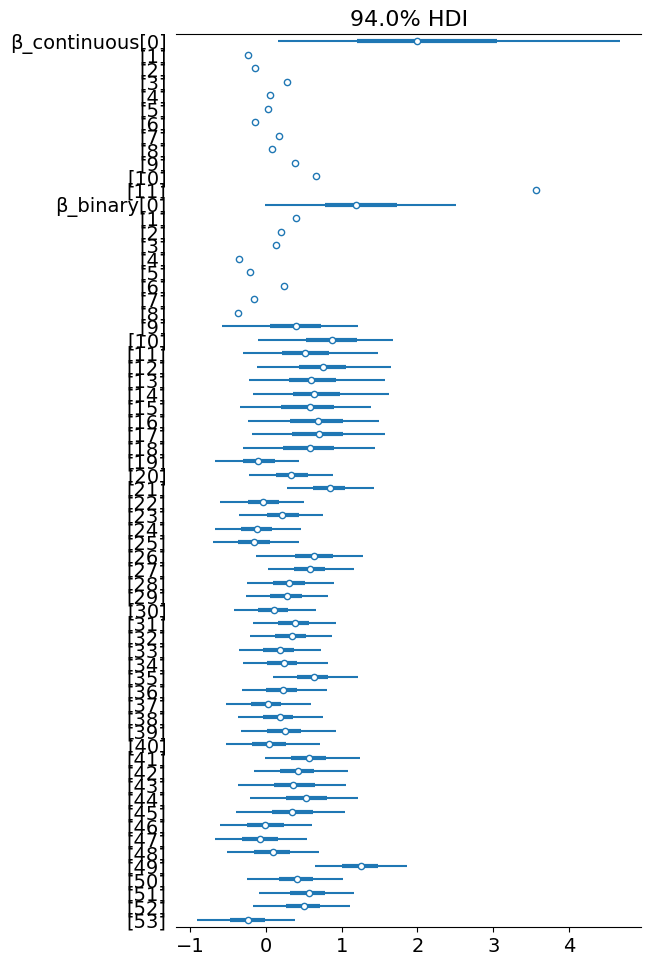

In [92]:
svgd_samples = 5000
grade_svgd_trace = approx.sample(svgd_samples)
with grade_model:
    az.plot_forest(grade_svgd_trace, var_names=['β_continuous', 'β_binary'])

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (66) in plot_posterior, generating only 40 plots
  warnings.warn(


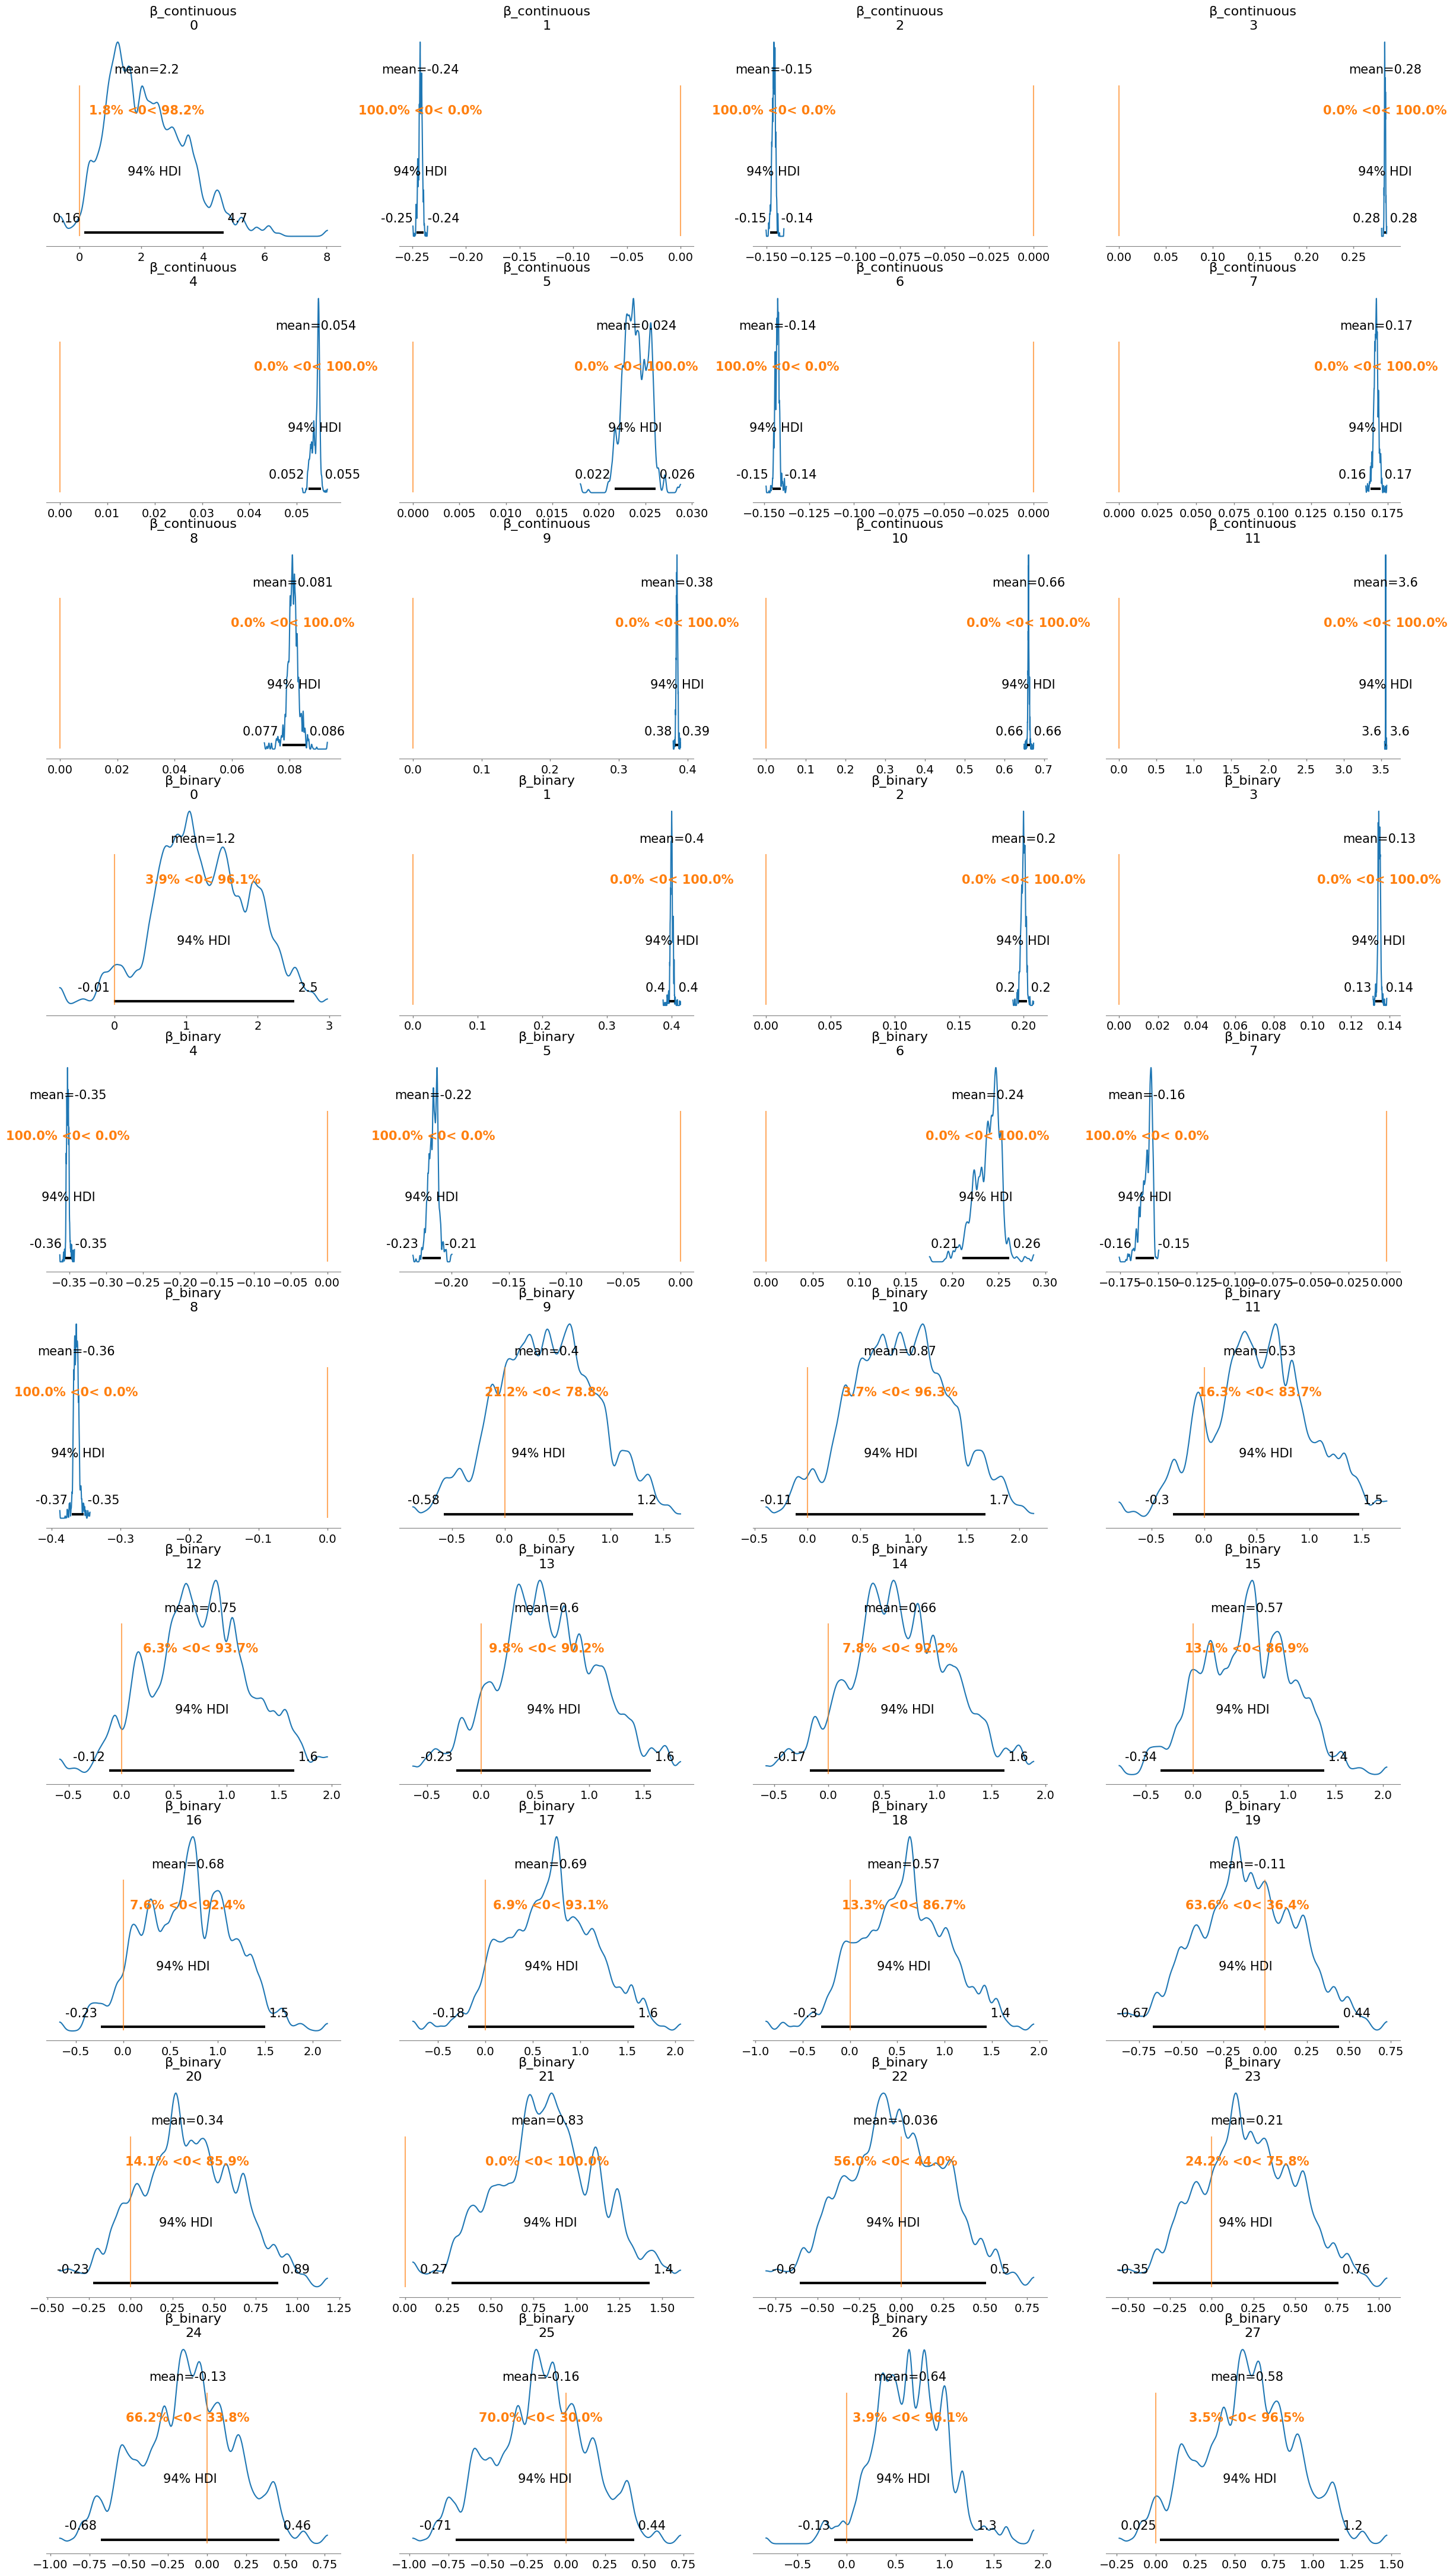

In [93]:
az.plot_posterior(
    grade_svgd_trace,
    var_names=['β_continuous', 'β_binary'], ref_val = 0
);

# Reduced Model

signficiant predictors

In [ ]:
insignificant_cols = ['sex_M',
'family_size_Less_than_or_equal_to_3',
'parent_status_Apart',
'mother_education_higher_education',
'mother_education_none',
'mother_education_secondary_education',
'father_education_none']

In [188]:
dummies_2_cat

school_support  family_support  extra_paid_classes  activities  \
0                 1               0                   0           0   
1                 0               1                   0           0   
2                 1               0                   1           0   
3                 0               1                   1           1   
4                 0               1                   1           0   
..              ...             ...                 ...         ...   
390               0               1                   1           0   
391               0               0                   0           0   
392               0               0                   0           0   
393               0               0                   0           0   
394               0               0                   0           0   

     nursery_school  higher_ed  internet_access  romantic_relationship  \
0                 1          1                0                      0   
1                 0          1                1                      0   
2                 1          1                1                      0   
3                 1          1                1                      1   
4                 1          1                0                      0   
..              ...        ...              ...                    ...   
390               1          1                0                      0   
391               0          1                1                      0   
392               0          1                0                      0   
393               0          1                1                      0   
394               1          1                1                      0   

     school_GP  school_MS  ...  guardian_mother  guardian_other  \
0            1          0  ...                1               0   
1            1          0  ...                0               0   
2            1          0  ...                1               0   
3            1          0  ...                1               0   
4            1          0  ...                0               0   
..         ...        ...  ...              ...             ...   
390          0          1  ...                0               1   
391          0          1  ...                1               0   
392          0          1  ...                0               1   
393          0          1  ...                1               0   
394          0          1  ...                0               0   

     travel_time_15_to_30_min.  travel_time_30_min._to_1_hour  \
0                            1                              0   
1                            0                              0   
2                            0                              0   
3                            0                              0   
4                            0                              0   
..                         ...                            ...   
390                          0                              0   
391                          1                              0   
392                          0                              0   
393                          0                              1   
394                          0                              0   

     travel_time_less_15_min.  travel_time_greater_1_hour  \
0                           0                           0   
1                           1                           0   
2                           1                           0   
3                           1                           0   
4                           1                           0   
..                        ...                         ...   
390                         1                           0   
391                         0                           0   
392                         1                           0   
393                         0                           0   
394   

In [189]:
dummies_2_cat_reduced = dummies_2_cat.drop(insignificant_cols, axis=1)

In [203]:
X_cat_reduced = dummies_2_cat_reduced
k_cat_reduced = X_cat_reduced.shape[1]
n_cat_reduced = X_cat_reduced.shape[0]
Ones_cat_reduced = np.ones(n_cat_reduced).reshape((n_cat_reduced,1))
X_cat_reduced = np.concatenate((Ones_cat_reduced, X_cat_reduced), axis = 1)

In [204]:
with pm.Model() as grade_model_reduced:
    β_continuous = pm.StudentT('β_continuous', nu=3, mu=0, lam=1, shape=X_int.shape[1])
    β_binary = pm.Normal('β_binary', mu=0, sigma=1, shape=X_cat_reduced.shape[1])

    # Combine beta coefficients
    β = pm.math.concatenate([β_continuous, β_binary])

    # Calculate the linear combination
    μ = pm.math.dot(X_int, β[:X_int.shape[1]]) + pm.math.dot(X_cat_reduced, β[X_int.shape[1]:])

    # Define the likelihood (normal distribution for continuous response)
    y_obs = pm.Normal('y_obs', mu=μ, sigma=1, observed=response)


g = pm.model_to_graphviz(grade_model_reduced)
g.render()

'.gv.pdf'

In [205]:
with grade_model_reduced:
    # Variational fit with ADVI optimization
    advi_fit_reduced = pm.fit(100000, method='advi', random_seed = 123)

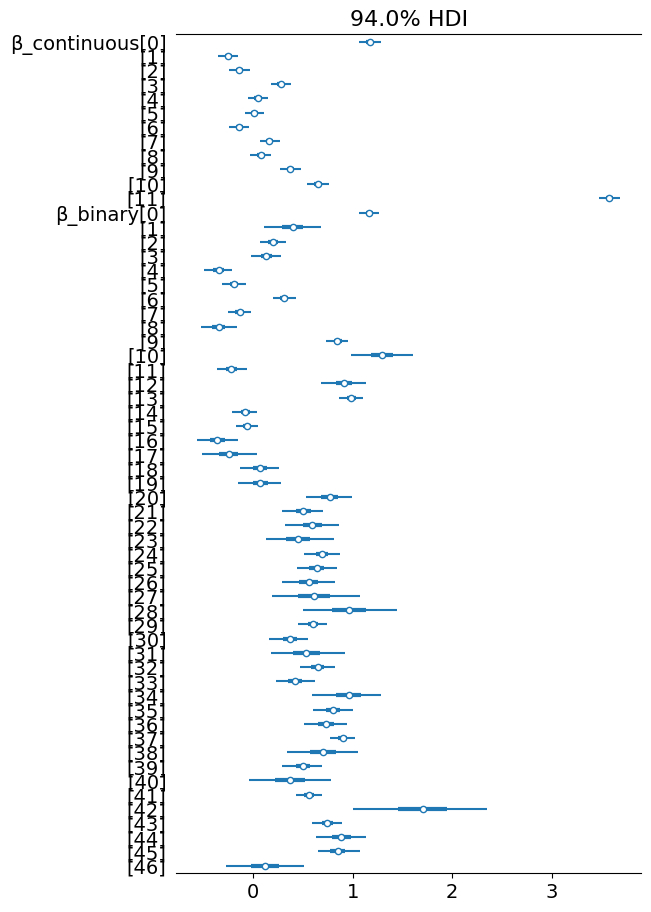

In [206]:
grade_advi_trace_reduced = advi_fit_reduced.sample(5000)

with grade_model_reduced:
    az.plot_forest(grade_advi_trace_reduced)

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (59) in plot_posterior, generating only 40 plots
  warnings.warn(


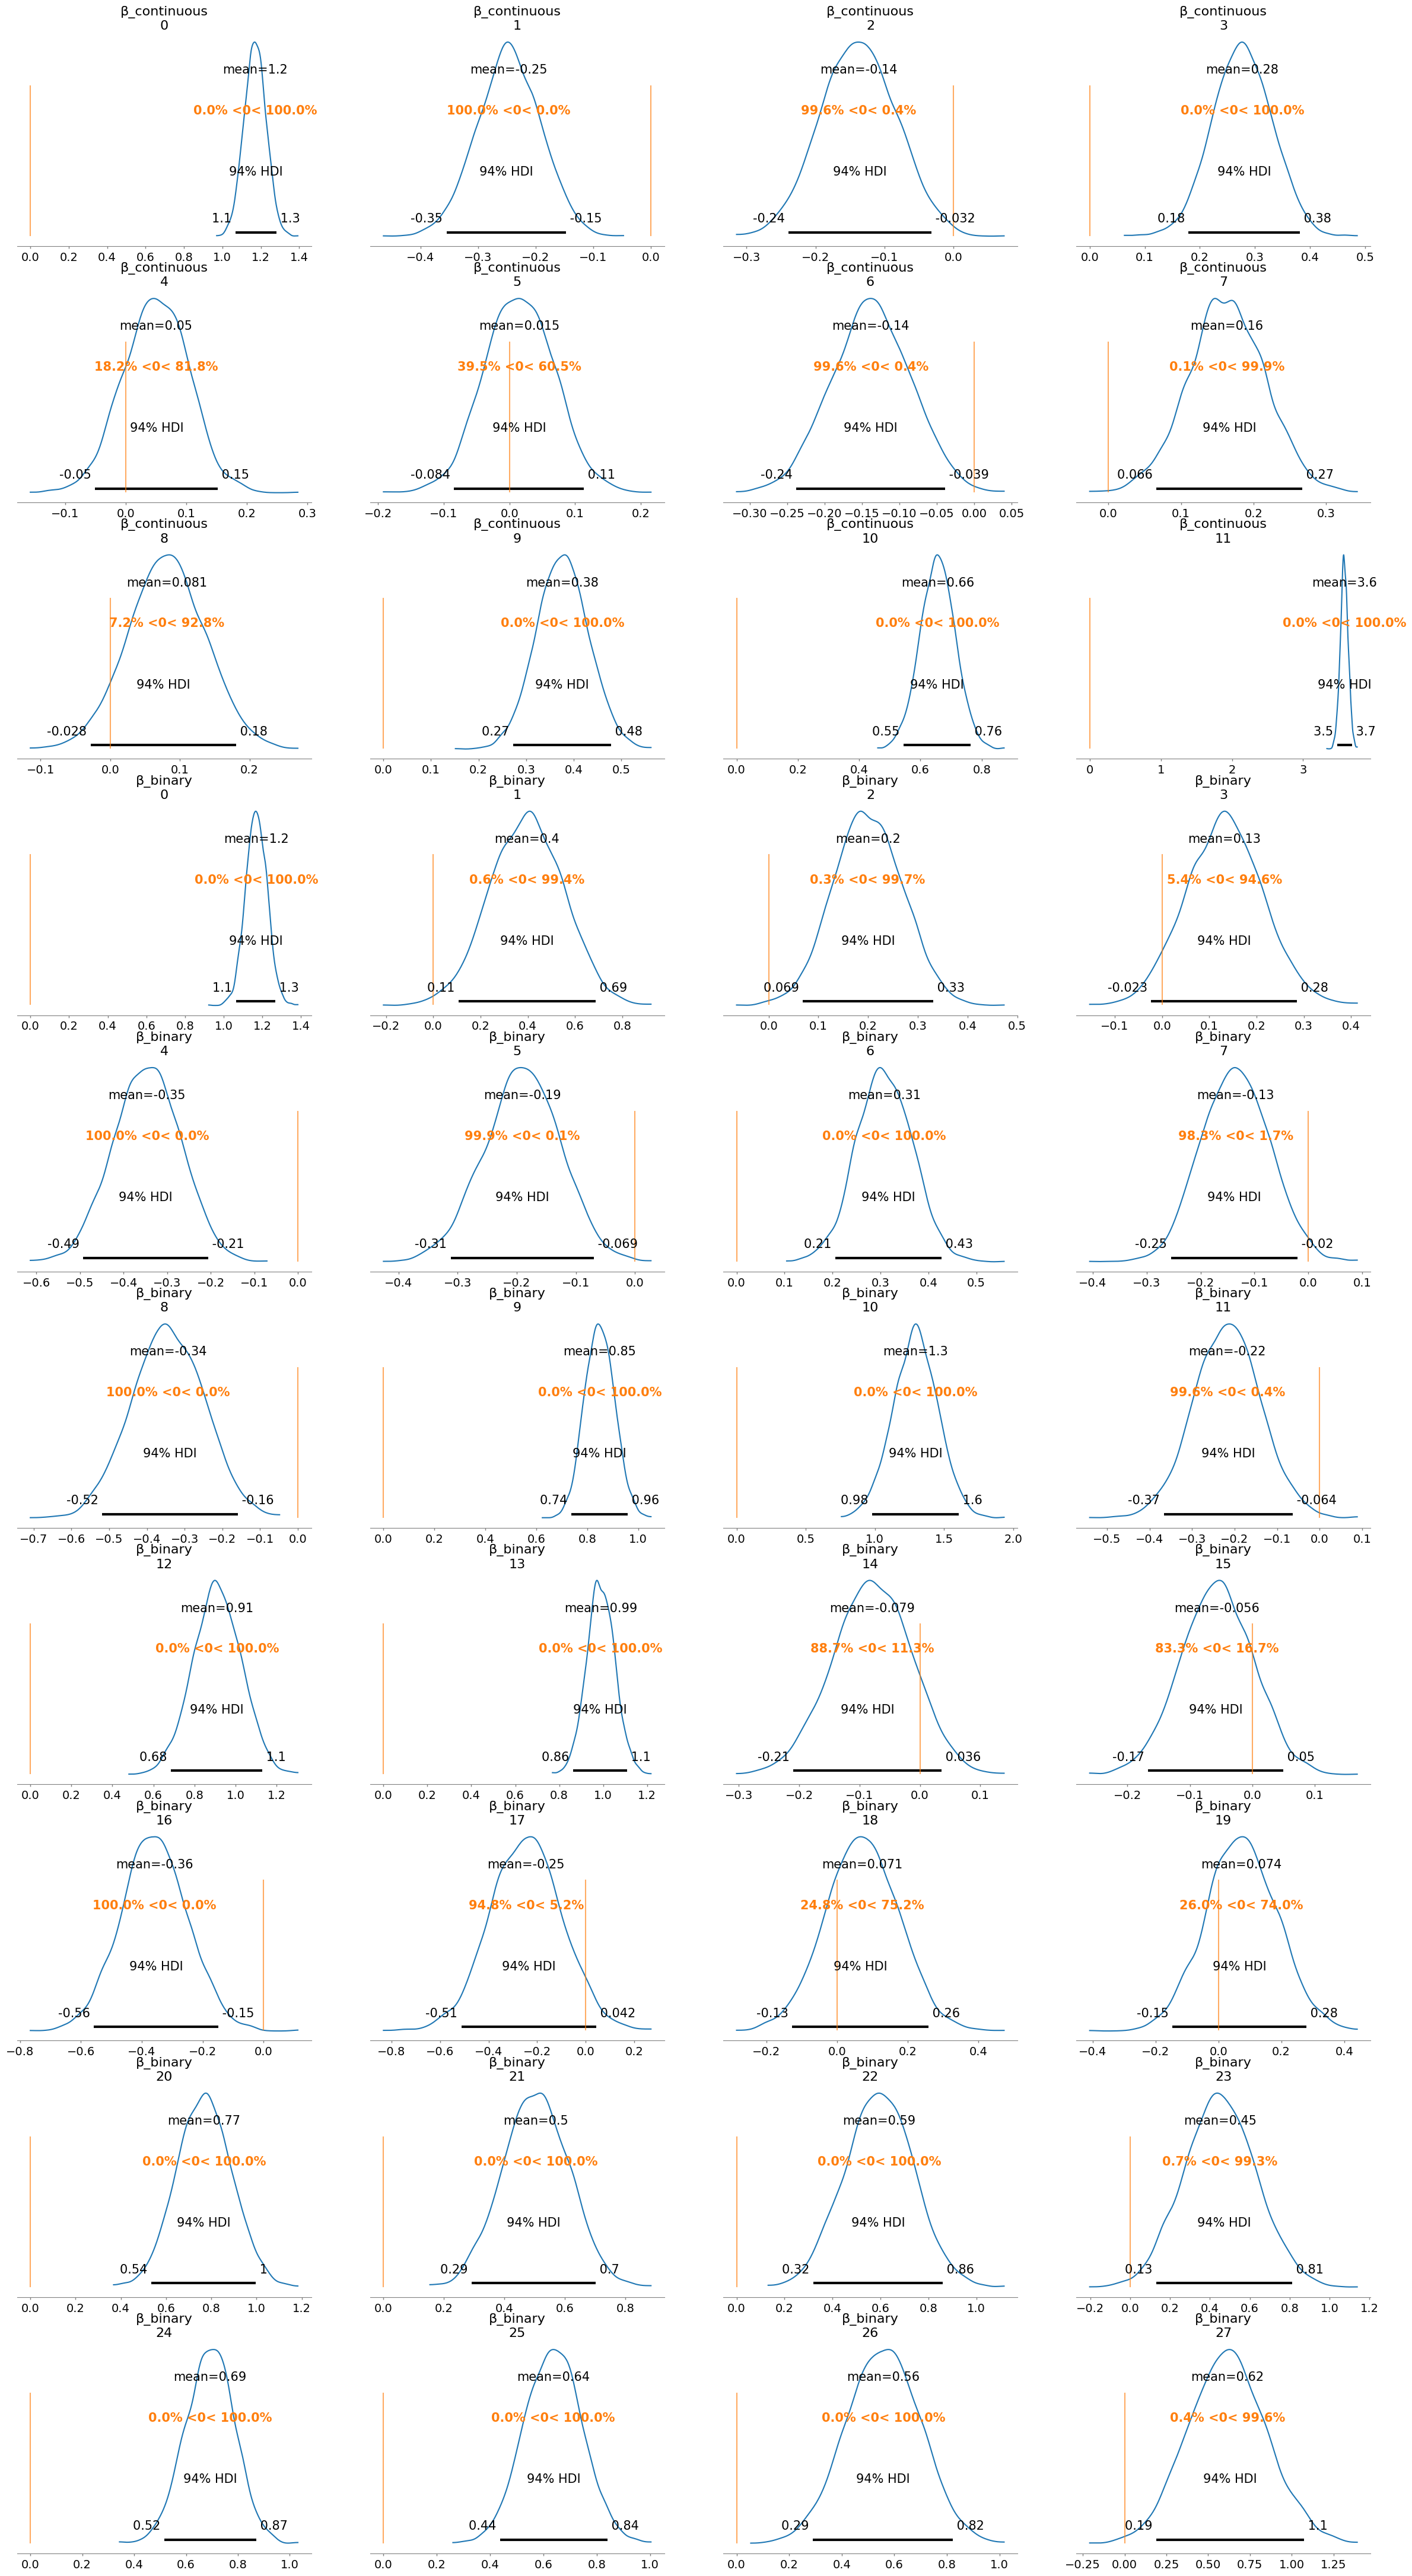

In [213]:
az.plot_posterior(
    grade_advi_trace_reduced, ref_val = 0
);

## Making Predictions
First we get the posterior beta values out. The lower of the interval will be used to make the lower predictions, then the mean to make the mean predictions, and upper upper predictions.

Full Model

In [166]:
results = az.summary(
    grade_advi_trace
)

print(results)

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β_continuous[0]  0.783  0.057   0.679    0.891      0.001    0.001    4597.0   
β_continuous[1] -0.237  0.055  -0.340   -0.135      0.001    0.001    4904.0   
β_continuous[2] -0.144  0.056  -0.252   -0.042      0.001    0.001    4600.0   
β_continuous[3]  0.282  0.054   0.185    0.383      0.001    0.001    4725.0   
β_continuous[4]  0.050  0.055  -0.057    0.150      0.001    0.001    4639.0   
...                ...    ...     ...      ...        ...      ...       ...   
β_binary[49]     1.499  0.364   0.829    2.202      0.006    0.004    4233.0   
β_binary[50]     0.534  0.077   0.386    0.672      0.001    0.001    4556.0   
β_binary[51]     0.686  0.137   0.430    0.940      0.002    0.001    4651.0   
β_binary[52]     0.634  0.110   0.419    0.829      0.002    0.001    4832.0   
β_binary[53]    -0.111  0.214  -0.505    0.285      0.003    0.002    5101.0   

                 ess_tail  r_hat  
β_co

In [167]:
beta_results = results[['mean','hdi_3%','hdi_97%']]

Reduced Model

In [207]:
results_reduced = az.summary(
    grade_advi_trace_reduced
)

print(results_reduced)

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β_continuous[0]   1.171  0.057   1.068    1.281      0.001    0.001    5094.0   
β_continuous[1]  -0.247  0.055  -0.354   -0.147      0.001    0.001    4812.0   
β_continuous[2]  -0.138  0.055  -0.239   -0.032      0.001    0.001    4767.0   
β_continuous[3]   0.277  0.055   0.180    0.381      0.001    0.001    5021.0   
β_continuous[4]   0.050  0.054  -0.050    0.152      0.001    0.001    5149.0   
β_continuous[5]   0.015  0.054  -0.084    0.114      0.001    0.001    4895.0   
β_continuous[6]  -0.138  0.053  -0.238   -0.039      0.001    0.001    4892.0   
β_continuous[7]   0.163  0.053   0.066    0.267      0.001    0.001    5069.0   
β_continuous[8]   0.081  0.055  -0.028    0.181      0.001    0.001    4658.0   
β_continuous[9]   0.376  0.055   0.273    0.479      0.001    0.001    4908.0   
β_continuous[10]  0.656  0.057   0.546    0.763      0.001    0.001    4953.0   
β_continuous[11]  3.578  0.0

In [208]:
beta_results_reduced = results_reduced[['mean','hdi_3%','hdi_97%']]

## Clean portuguese data

In [246]:
test_data = pd.read_csv("student_portuguese_clean.csv")

In [247]:
test_data.isna().sum()

student_id               0
school                   0
sex                      0
age                      0
address_type             0
family_size              0
parent_status            0
mother_education         0
father_education         0
mother_job               0
father_job               0
school_choice_reason     0
guardian                 0
travel_time              0
study_time               0
class_failures           0
school_support           0
family_support           0
extra_paid_classes       0
activities               0
nursery_school           0
higher_ed                0
internet_access          0
romantic_relationship    0
family_relationship      0
free_time                0
social                   0
weekday_alcohol          0
weekend_alcohol          0
health                   0
absences                 0
grade_1                  0
grade_2                  0
final_grade              0
dtype: int64

In [252]:
clean_test = test_data.copy(deep=True)

In [256]:
clean_test = clean_test.replace(replace_map)
dummies_test = pd.get_dummies(clean_test, dtype=int)
dummies_test.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
dummies_test.rename(columns=lambda x: x.replace('(', ''), inplace=True)
dummies_test.rename(columns=lambda x: x.replace(')', ''), inplace=True)
dummies_test.rename(columns=lambda x: x.replace('<', 'less_'), inplace=True)
dummies_test.rename(columns=lambda x: x.replace('>', 'greater_'), inplace=True)

dummies_test_predict = dummies_test.drop('final_grade',axis=1)
dummies_test_predict = dummies_test_predict.drop('student_id',axis=1)

dummies_test_predict.shape

(649, 64)

In [257]:
int_cols = [
 'age',
 'class_failures',
 'family_relationship',
 'free_time',
 'social',
 'weekday_alcohol',
 'weekend_alcohol',
 'health',
 'absences',
 'grade_1',
 'grade_2']

In [258]:
# standardize num predictors
integer_data = dummies_test_predict[int_cols]
scaler = StandardScaler()
standardized_integer_data = pd.DataFrame(scaler.fit_transform(integer_data), columns=int_cols)
dummies_test_predict[int_cols] = standardized_integer_data

In [259]:
dummies_test_predict.shape

(649, 64)

## Standardize Actual Grades

In [263]:
actual_test_grades = dummies_test[['final_grade']]
actual_test_grades

final_grade
0             11
1             11
2             12
3             14
4             13
..           ...
644           10
645           16
646            9
647           10
648           11

[649 rows x 1 columns]

## Full Model - Predict on Test Data

In [264]:
bo_cnts = beta_results.loc['β_continuous[0]']
bo_bin = beta_results.loc['β_binary[0]']

drop_index = ['β_continuous[0]', 'β_binary[0]']
preds = beta_results.drop(index=drop_index)

In [265]:
predictions_mean = np.dot(dummies_test_predict, preds[['mean']]) + bo_cnts['mean'] + bo_bin['mean']
predictions_lower = np.dot(dummies_test_predict, preds[['hdi_3%']]) + bo_cnts['hdi_3%'] + bo_bin['hdi_3%']
predictions_upper = np.dot(dummies_test_predict, preds[['hdi_97%']]) + bo_cnts['hdi_97%'] + bo_bin['hdi_97%']

predict_mean_df = pd.DataFrame(predictions_mean, columns=['prediction'])
predict_lower_df = pd.DataFrame(predictions_lower, columns=['prediction'])
predict_upper_df = pd.DataFrame(predictions_upper, columns=['prediction'])

In [266]:
actual_test_grades

final_grade
0             11
1             11
2             12
3             14
4             13
..           ...
644           10
645           16
646            9
647           10
648           11

[649 rows x 1 columns]

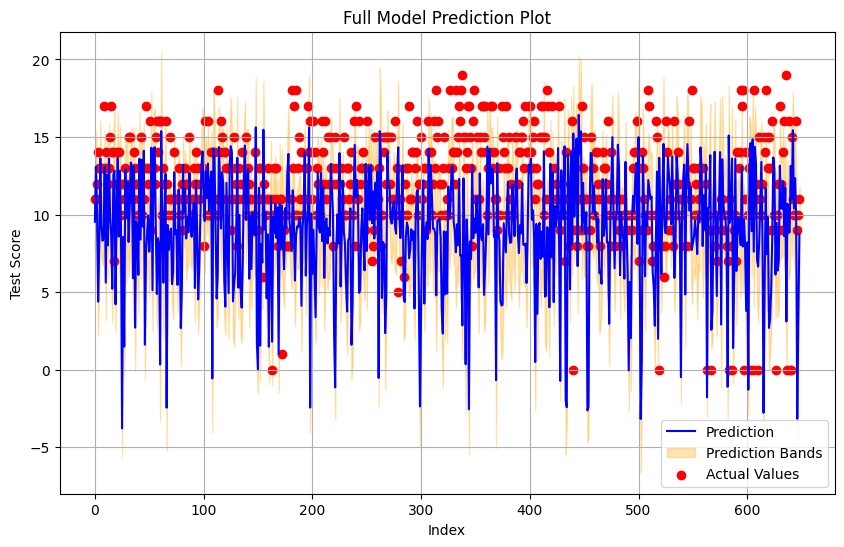

In [300]:
plt.figure(figsize=(10, 6))

# Mean predictions
plt.plot(predict_mean_df['prediction'], label='Prediction', color='blue')

# Upper and lower bounds
plt.fill_between(predict_lower_df.index, predict_lower_df['prediction'], predict_upper_df['prediction'], color='orange', alpha=0.3, label='Prediction Bands')

# Actual values
plt.scatter(actual_test_grades.index, actual_test_grades.final_grade, label='Actual Values', color='red')

plt.title('Full Model Prediction Plot')
plt.xlabel('Index')
plt.ylabel('Test Score')
plt.legend()
plt.grid(True)
plt.show()

## Reduced model

In [268]:
dummies_test_reduced = dummies_test_predict.drop(insignificant_cols, axis=1)

In [269]:
bo_cnts = beta_results_reduced.loc['β_continuous[0]']
bo_bin = beta_results_reduced.loc['β_binary[0]']

preds_reduced = beta_results_reduced.drop(index=drop_index)

preds_reduced.shape

(57, 3)

In [271]:
predictions_mean = np.dot(dummies_test_reduced, preds_reduced[['mean']]) + bo_cnts['mean'] + bo_bin['mean']
predictions_lower = np.dot(dummies_test_reduced, preds_reduced[['hdi_3%']]) + bo_cnts['hdi_3%'] + bo_bin['hdi_3%']
predictions_upper = np.dot(dummies_test_reduced, preds_reduced[['hdi_97%']]) + bo_cnts['hdi_97%'] + bo_bin['hdi_97%']

predict_mean_df = pd.DataFrame(predictions_mean, columns=['prediction'])
predict_lower_df = pd.DataFrame(predictions_lower, columns=['prediction'])
predict_upper_df = pd.DataFrame(predictions_upper, columns=['prediction'])

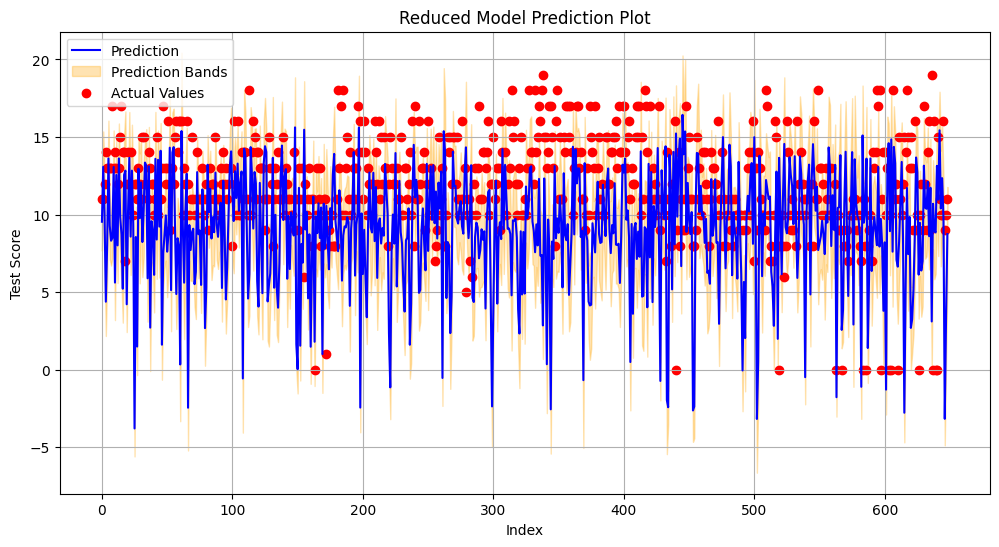

In [299]:
plt.figure(figsize=(12, 6))

# Mean predictions
plt.plot(predict_mean_df['prediction'], label='Prediction', color='blue')

# Upper and lower bounds
plt.fill_between(predict_lower_df.index, predict_lower_df['prediction'], predict_upper_df['prediction'], color='orange', alpha=0.3, label='Prediction Bands')

# Actual values
plt.scatter(actual_test_grades.index, actual_test_grades.final_grade, label='Actual Values', color='red')

plt.title('Reduced Model Prediction Plot')
plt.xlabel('Index')
plt.ylabel('Test Score')
plt.legend()
plt.grid(True)
plt.show()

## Predictions on Math Data
for comparison

In [272]:
int_columns_test = ['age',
 'class_failures',
 'family_relationship',
 'free_time',
 'social',
 'weekday_alcohol',
 'weekend_alcohol',
 'health',
 'absences',
 'grade_1',
 'grade_2',
 'final_grade']

In [273]:
# Standardize num predictors
integer_data_test = dummies_2[int_columns_test]
standardized_integer_data_test = pd.DataFrame(scaler.fit_transform(integer_data_test), columns=int_columns_test)
dummies_2[int_columns_test] = standardized_integer_data_test

In [274]:
dummies_math_predict = dummies_2.drop('final_grade',axis=1)

In [275]:
predictions_mean_math = np.dot(dummies_math_predict, preds[['mean']]) + bo_cnts['mean'] + bo_bin['mean']
predictions_lower_math = np.dot(dummies_math_predict, preds[['hdi_3%']]) + bo_cnts['hdi_3%'] + bo_bin['hdi_3%']
predictions_upper_math = np.dot(dummies_math_predict, preds[['hdi_97%']]) + bo_cnts['hdi_97%'] + bo_bin['hdi_97%']

math_mean_df = pd.DataFrame(predictions_mean_math, columns=['prediction'])
math_lower_df = pd.DataFrame(predictions_lower_math, columns=['prediction'])
math_upper_df = pd.DataFrame(predictions_upper_math, columns=['prediction'])

In [296]:
response = pd.DataFrame(response)

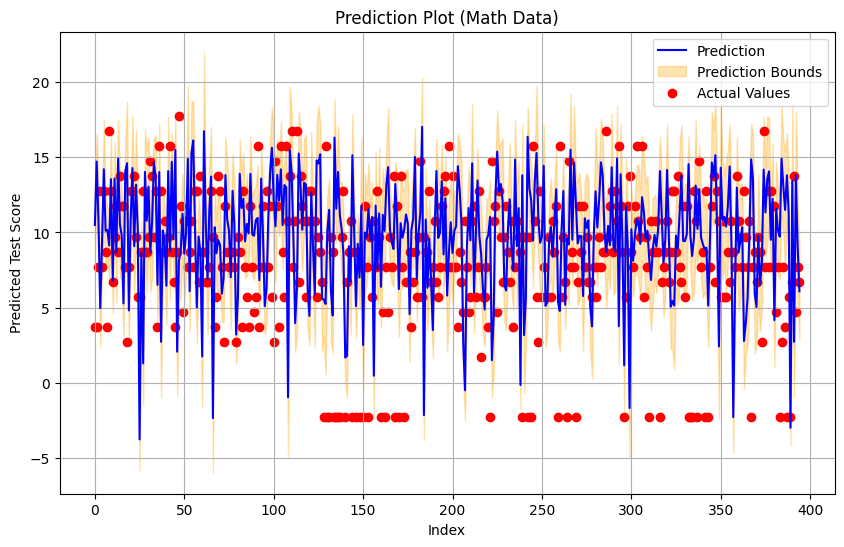

In [297]:
plt.figure(figsize=(10, 6))

# Mean predictions
plt.plot(math_mean_df['prediction'], label='Prediction', color='blue')

# Upper and lower bounds
plt.fill_between(math_lower_df.index, math_lower_df['prediction'], math_upper_df['prediction'], color='orange', alpha=0.3, label='Prediction Bounds')

# Actual values
plt.scatter(response.index, response.final_grade, label='Actual Values', color='red')

plt.title('Prediction Plot (Math Data)')
plt.xlabel('Index')
plt.ylabel('Predicted Test Score')
plt.legend()
plt.grid(True)
plt.show()